In [3]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from datetime import datetime, timedelta

In [4]:
datapath = '../data/'

In [5]:
import glob
files = glob.glob(datapath+'*.csv')
files[0]

'../data/FC3DC207-9459-4CBE-8AB5-0E0AC77D5FEC.csv'

In [6]:
dfs = [pd.read_csv(f) for f in files]
dfs[1] = dfs[1].rename(columns={" timestamp ": "timestamp"})

In [7]:
for df in dfs:
    df['mag'] = np.sqrt(df['x']**2+df['y']**2+df['z']**2)
    df['time'] = pd.to_datetime(df['timestamp'], unit='ms')
dfs[0].head(5)

timestamp           type        lat        lon      height  accuracy  \
0  1.431035e+12            gps  41.978753 -87.893018  194.760063      10.0   
1  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   
2  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   
3  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   
4  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   

   speed     bearing         x         y         z       mag  \
0  14.36  139.570312       NaN       NaN       NaN       NaN   
1    NaN         NaN -0.075974 -0.448395 -0.867188  0.979206   
2    NaN         NaN -0.079025 -0.435837 -0.919876  1.020966   
3    NaN         NaN -0.069183 -0.456039 -0.921722  1.030694   
4    NaN         NaN -0.059341 -0.456772 -0.896149  1.007593   

                        time  
0 2015-05-07 21:46:58.761430  
1 2015-05-07 21:46:58.834430  
2 2015-05-07 21:46:58.932430  
3 2015-05-07 21:46:59.030430  
4 2015-05-07 21:46:59.129430

In [8]:
def prepare_dfs(dfs,window):
    sorted_dfs = []
    rolling_mean = []
    rolling_std = []
    for df in dfs:
        _temp = df.sort_values(by='time')
        _temp = _temp.set_index(['time'])

        _mean = _temp.rolling(window).mean()
        _std = _temp.rolling(window).std()
    
        sorted_dfs.append(_temp)
        rolling_mean.append(_mean)
        rolling_std.append(_std)
    
    return sorted_dfs, rolling_mean, rolling_std



In [9]:
sorted_dfs, rolling_mean, rolling_std = prepare_dfs(dfs,'1s')

In [10]:
def Find_events(dfs, variable, window):
    events_df = pd.DataFrame()
    drivers = []
    for i in range(6,24):
        test = dfs[i].sort_values(by='time')
        test = test.set_index(['time'])

        test2 = test.rolling(window).mean()
        test2_std = test.rolling(window).std()

        orig_df = dfs[i][['time',variable]]
        orig_df = orig_df.set_index(['time'])
        orig_df_plot = orig_df.dropna(axis=0,how='any')


        for j in range(0,len(test.index)):
            if test[variable][j] > (test2[variable][j]+(2.9*test2_std[variable][j])):
                #print(i,test2.index[j])
                events_df = events_df.append(test.iloc[j])
                drivers.append(i)
    events_df['driver']=drivers
    return events_df
                

In [11]:
event = Find_events(dfs,'mag','1s')

In [12]:
def Plot_crash(event, raw_profile, rolling_mean):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
    
    ax1.plot(raw_profile.index,raw_profile.mag)
    ax1.plot(rolling_mean.index, rolling_mean.mag)
    ax1.plot(event.index,event.mag, marker='*',markersize=20,c='k')
 
    ax2.plot(raw_profile.index,raw_profile.mag)
    ax2.plot(rolling_mean.index, rolling_mean.mag)
    ax2.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax2.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
             
    speed_df = raw_profile[['speed','lat','lon','height']].dropna(axis=0)
    ax3.plot(speed_df.index,speed_df.speed)
    ax3.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    
    ax4.plot(speed_df.index,speed_df.speed)
    ax4.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax4.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    
    
    
    plt.show()

In [14]:
#for i in range(0,len(event.index)):
    #Plot_crash(event.iloc[i:i+1],sorted_dfs[event.driver[i]], rolling_mean[event.driver[i]])
    
    
    
    

In [15]:
def Gather_info(event, dfs, time):
    
    speed_mean_before=[]
    speed_mean_after =[]
    force_mean_before=[]
    force_mean_after =[]    
    
    for i in range(0,len(event.index)):
        
        before = dfs[event.driver[i]][ (dfs[event.driver[i]].index> (event.index[i]-timedelta(seconds=time) )) & 
                       (dfs[event.driver[i]].index< (event.index[i]))]

        after = dfs[event.driver[i]][ (dfs[event.driver[i]].index> (event.index[i])) & 
                       (dfs[event.driver[i]].index< (event.index[i]+timedelta(seconds=time) ))]
        
        speed_mean_before.append(before.speed.mean())
        speed_mean_after.append(after.speed.mean())
        force_mean_before.append(before.mag.mean())
        force_mean_after.append(after.mag.mean())        
        
    event['speed_before'] = speed_mean_before
    event['speed_after']  = speed_mean_after     
    event['mag_before']   = force_mean_before    
    event['mag_after']    = force_mean_after
    
    return event
    
    
    

In [16]:
event.head()

accuracy  bearing  height  lat  lon       mag  \
2015-03-19 20:50:03.761870       NaN      NaN     NaN  NaN  NaN  1.076214   
2015-03-19 20:53:07.782870       NaN      NaN     NaN  NaN  NaN  1.591640   
2015-03-19 20:53:11.084870       NaN      NaN     NaN  NaN  NaN  1.748581   
2015-03-19 20:53:13.320870       NaN      NaN     NaN  NaN  NaN  2.165949   
2015-03-19 21:07:17.232870       NaN      NaN     NaN  NaN  NaN  1.596844   

                            speed     timestamp           type         x  \
2015-03-19 20:50:03.761870    NaN  1.426798e+12  accelerometer -0.751694   
2015-03-19 20:53:07.782870    NaN  1.426798e+12  accelerometer  0.338928   
2015-03-19 20:53:11.084870    NaN  1.426798e+12  accelerometer -0.224045   
2015-03-19 20:53:13.320870    NaN  1.426798e+12  accelerometer  0.226974   
2015-03-19 21:07:17.232870    NaN  1.426799e+12  accelerometer -0.665009   

                                   y         z  driver  
2015-03-19 20:50:03.761870  0.765961 -0.080612       6  
2015-03-19 20:53:07.782870 -0.938950 -1.239685       6  
2015-03-19 20:53:11.084870 -0.291351 -1.709518       6  
2015-03-19 20:53:13.320870 -2.078445 -0.565582       6  
2015-03-19 21:07:17.232870 -0.065903  1.450287       6

In [17]:
event = Gather_info(event, sorted_dfs, 30)

In [18]:
event.head()

accuracy  bearing  height  lat  lon       mag  \
2015-03-19 20:50:03.761870       NaN      NaN     NaN  NaN  NaN  1.076214   
2015-03-19 20:53:07.782870       NaN      NaN     NaN  NaN  NaN  1.591640   
2015-03-19 20:53:11.084870       NaN      NaN     NaN  NaN  NaN  1.748581   
2015-03-19 20:53:13.320870       NaN      NaN     NaN  NaN  NaN  2.165949   
2015-03-19 21:07:17.232870       NaN      NaN     NaN  NaN  NaN  1.596844   

                            speed     timestamp           type         x  \
2015-03-19 20:50:03.761870    NaN  1.426798e+12  accelerometer -0.751694   
2015-03-19 20:53:07.782870    NaN  1.426798e+12  accelerometer  0.338928   
2015-03-19 20:53:11.084870    NaN  1.426798e+12  accelerometer -0.224045   
2015-03-19 20:53:13.320870    NaN  1.426798e+12  accelerometer  0.226974   
2015-03-19 21:07:17.232870    NaN  1.426799e+12  accelerometer -0.665009   

                                   y         z  driver  speed_before  \
2015-03-19 20:50:03.761870  0.765961 -0.080612       6      0.918000   
2015-03-19 20:53:07.782870 -0.938950 -1.239685       6      0.067667   
2015-03-19 20:53:11.084870 -0.291351 -1.709518       6      0.040000   
2015-03-19 20:53:13.320870 -2.078445 -0.565582       6      0.040000   
2015-03-19 21:07:17.232870 -0.065903  1.450287       6      3.716333   

                            speed_after  mag_before  mag_after  
2015-03-19 20:50:03.761870     2.974667    0.989548   1.007291  
2015-03-19 20:53:07.782870     0.671000    1.013983   1.051409  
2015-03-19 20:53:11.084870     0.857667    1.017548   1.047496  
2015-03-19 20:53:13.320870     0.884333    1.020831   1.044272  
2015-03-19 21:07:17.232870     1.026667    0.984320   0.998906

In [19]:
event.head(5)

accuracy  bearing  height  lat  lon       mag  \
2015-03-19 20:50:03.761870       NaN      NaN     NaN  NaN  NaN  1.076214   
2015-03-19 20:53:07.782870       NaN      NaN     NaN  NaN  NaN  1.591640   
2015-03-19 20:53:11.084870       NaN      NaN     NaN  NaN  NaN  1.748581   
2015-03-19 20:53:13.320870       NaN      NaN     NaN  NaN  NaN  2.165949   
2015-03-19 21:07:17.232870       NaN      NaN     NaN  NaN  NaN  1.596844   

                            speed     timestamp           type         x  \
2015-03-19 20:50:03.761870    NaN  1.426798e+12  accelerometer -0.751694   
2015-03-19 20:53:07.782870    NaN  1.426798e+12  accelerometer  0.338928   
2015-03-19 20:53:11.084870    NaN  1.426798e+12  accelerometer -0.224045   
2015-03-19 20:53:13.320870    NaN  1.426798e+12  accelerometer  0.226974   
2015-03-19 21:07:17.232870    NaN  1.426799e+12  accelerometer -0.665009   

                                   y         z  driver  speed_before  \
2015-03-19 20:50:03.761870  0.765961 -0.080612       6      0.918000   
2015-03-19 20:53:07.782870 -0.938950 -1.239685       6      0.067667   
2015-03-19 20:53:11.084870 -0.291351 -1.709518       6      0.040000   
2015-03-19 20:53:13.320870 -2.078445 -0.565582       6      0.040000   
2015-03-19 21:07:17.232870 -0.065903  1.450287       6      3.716333   

                            speed_after  mag_before  mag_after  
2015-03-19 20:50:03.761870     2.974667    0.989548   1.007291  
2015-03-19 20:53:07.782870     0.671000    1.013983   1.051409  
2015-03-19 20:53:11.084870     0.857667    1.017548   1.047496  
2015-03-19 20:53:13.320870     0.884333    1.020831   1.044272  
2015-03-19 21:07:17.232870     1.026667    0.984320   0.998906

In [72]:
def Plot_crash(event, raw_profile, rolling_mean):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
    
    ax1.plot(raw_profile.index,raw_profile.mag)
    ax1.plot(rolling_mean.index, rolling_mean.mag)
    ax1.plot(event.index,event.mag, marker='*',markersize=20,c='k')
 
    ax2.plot(raw_profile.index,raw_profile.mag)
    ax2.plot(rolling_mean.index, rolling_mean.mag)
    ax2.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax2.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
             
    speed_df = raw_profile[['speed','lat','lon','height']].dropna(axis=0)
    ax3.plot(speed_df.index,speed_df.speed)
    ax3.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    
    ax4.plot(speed_df.index,speed_df.speed)
    ax4.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax4.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-1, event.speed_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-3, event.speed_after[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-5, event.mag_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-7, event.mag_after[0])
    
    
    
    
    plt.show()

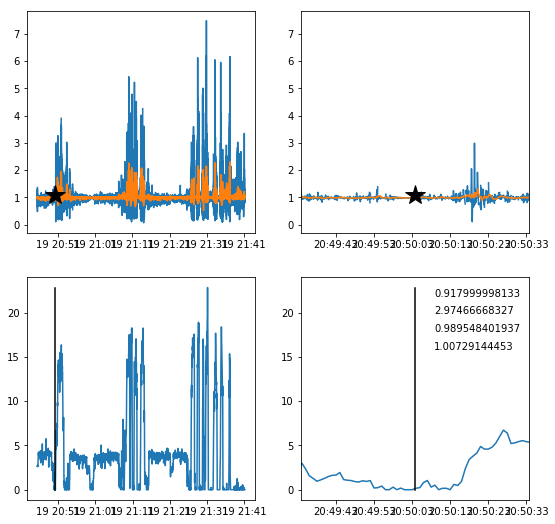

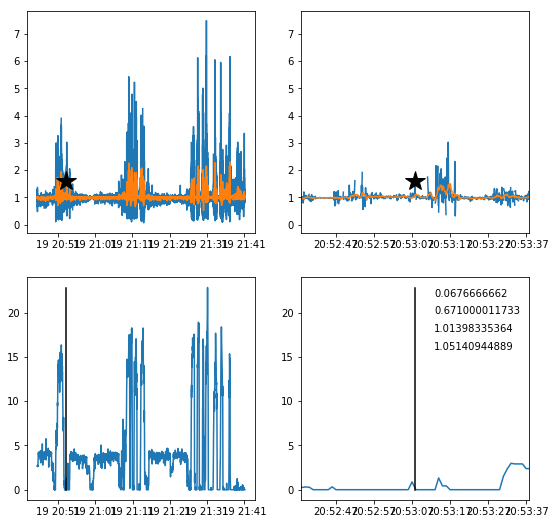

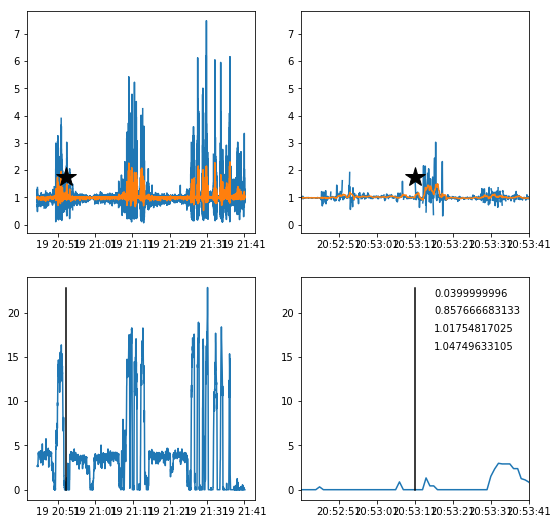

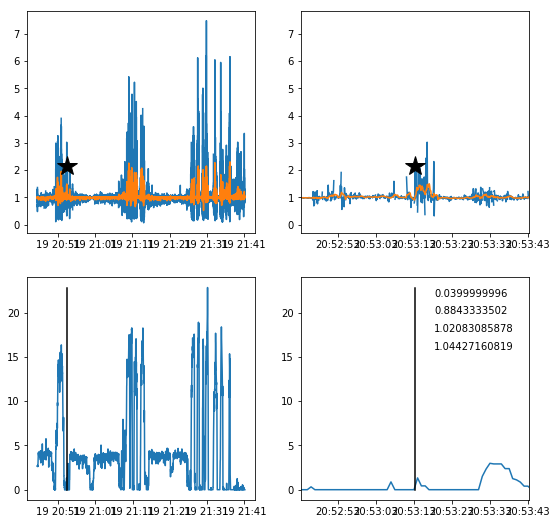

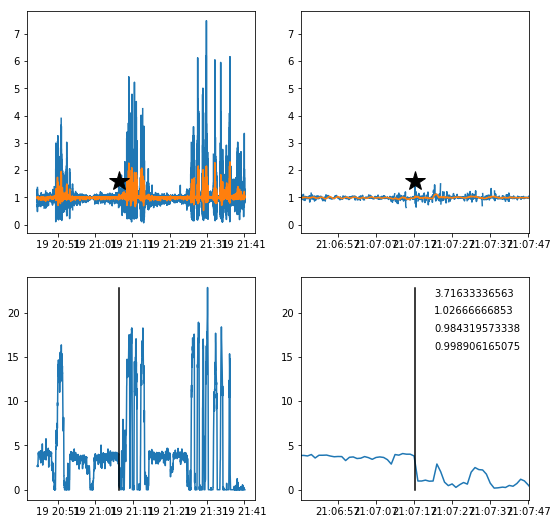

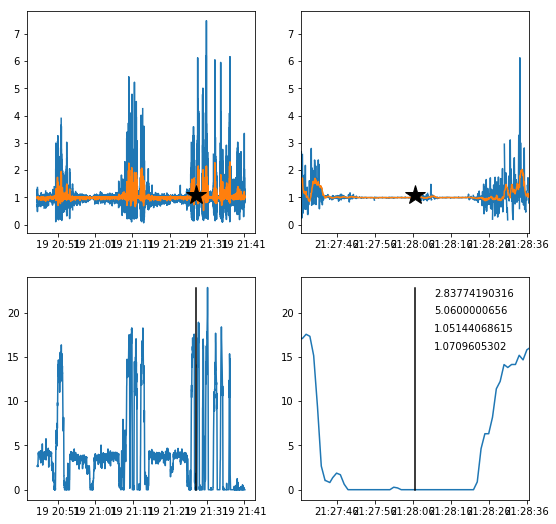

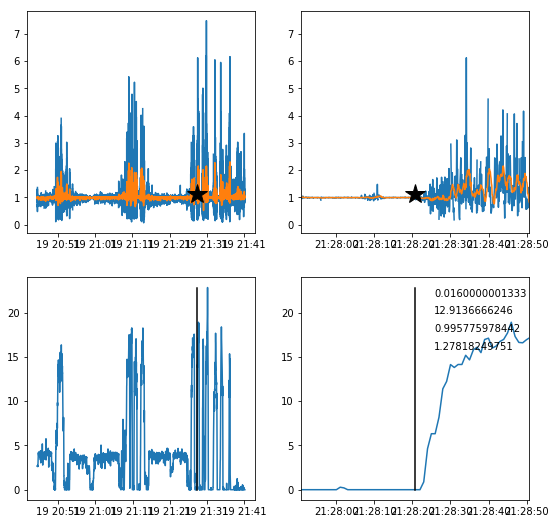

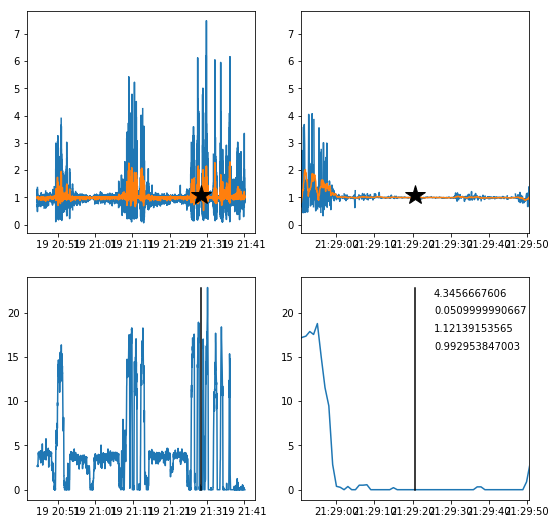

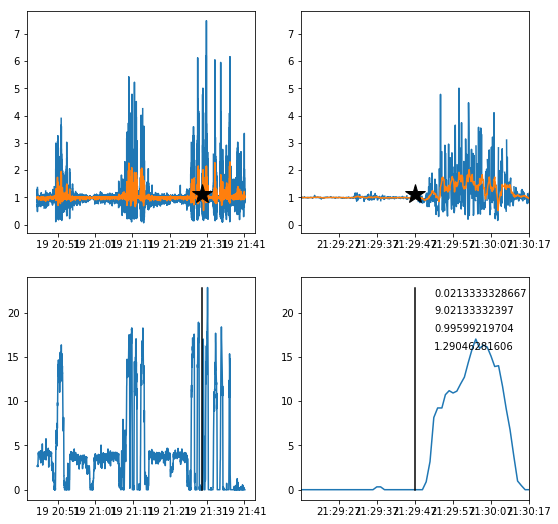

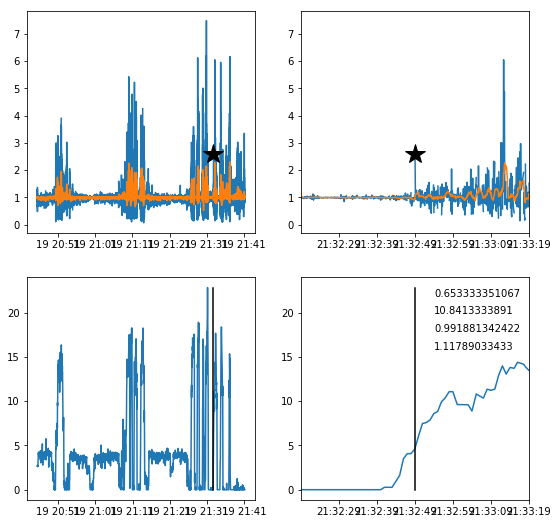

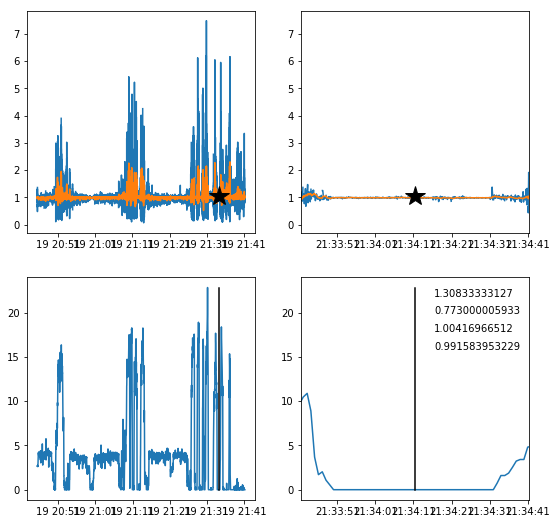

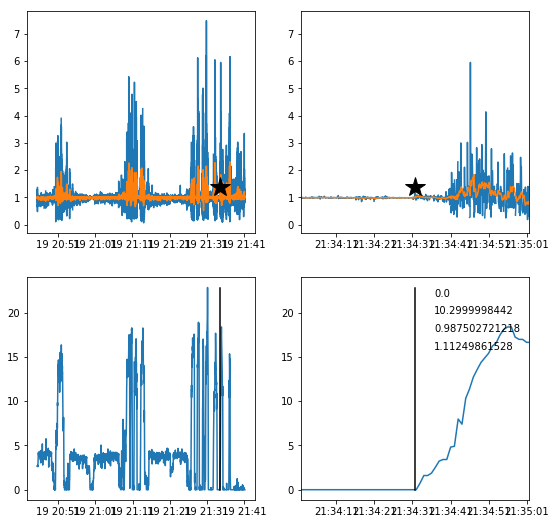

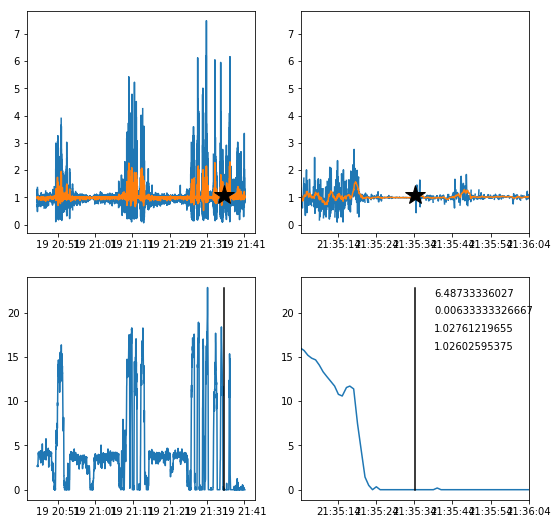

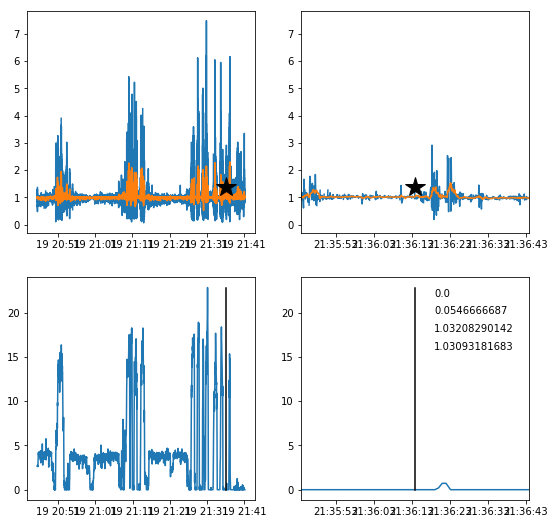

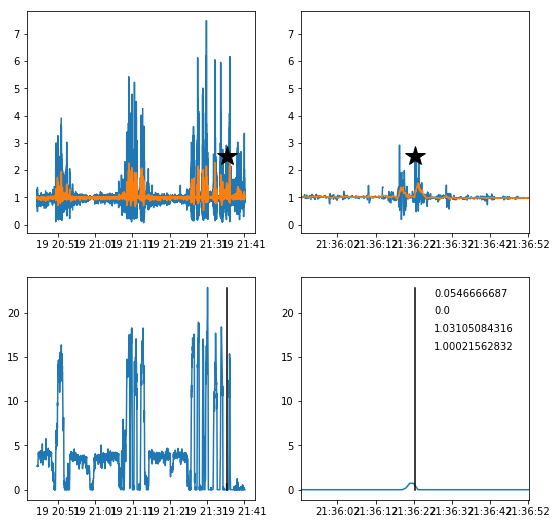

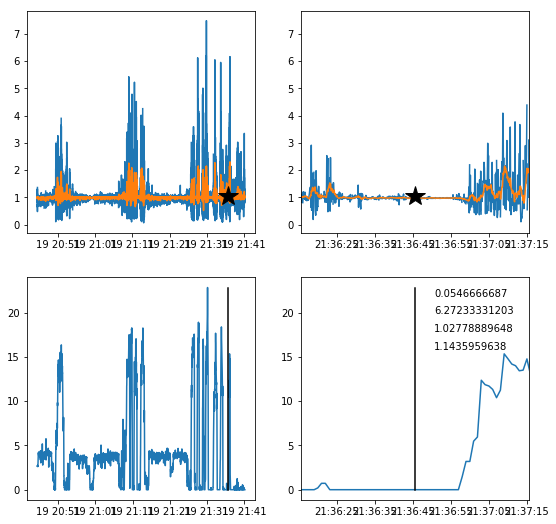

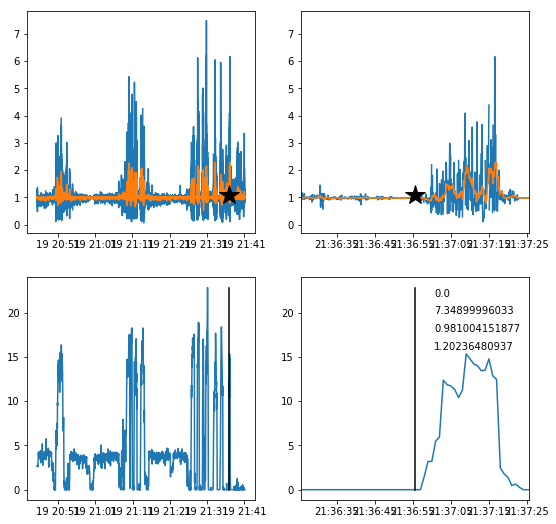

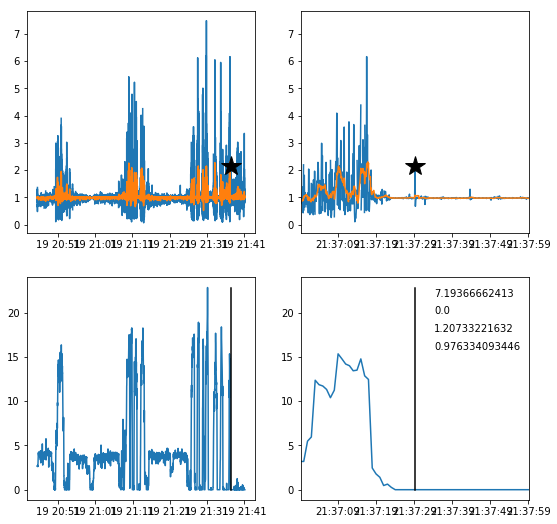

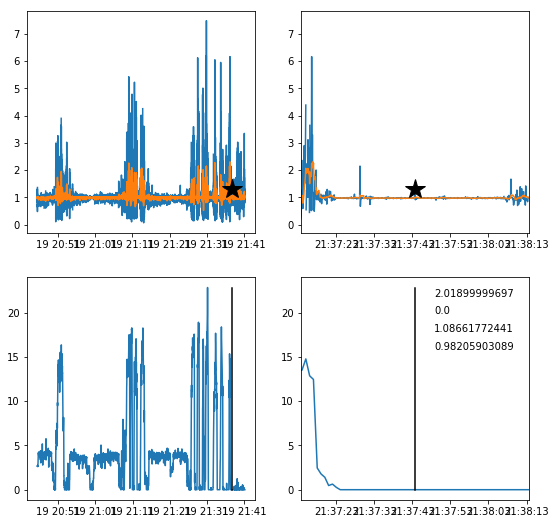

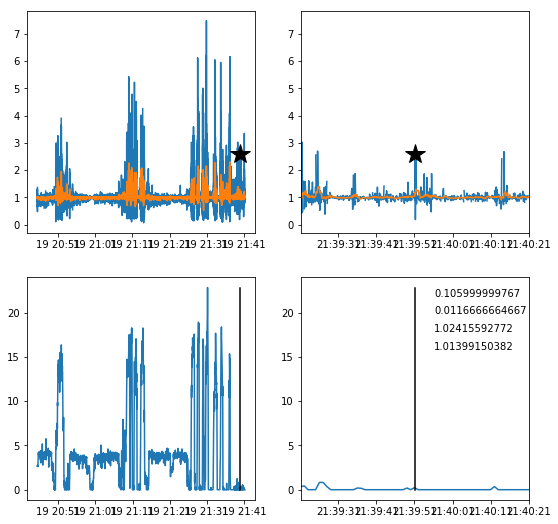

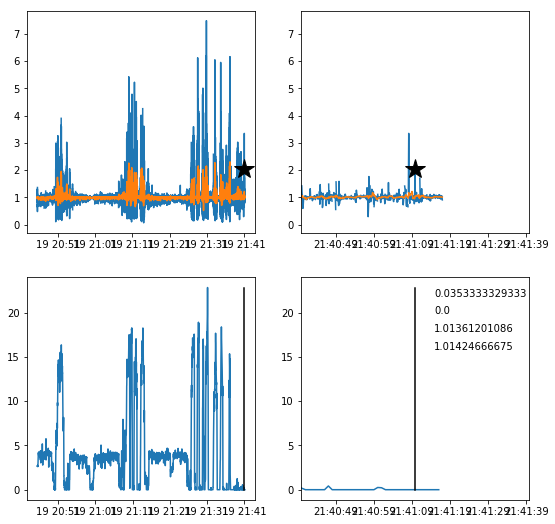

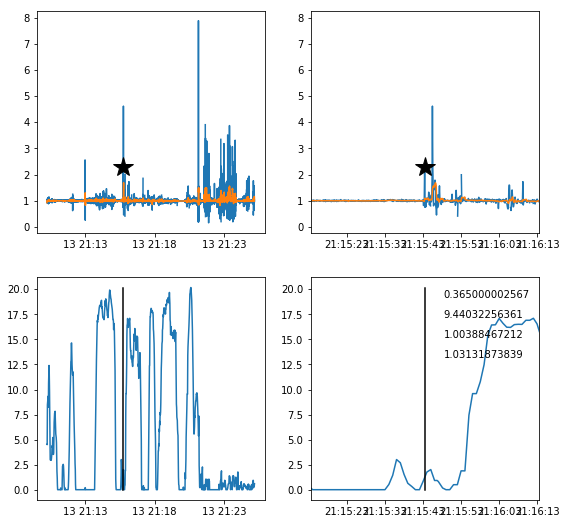

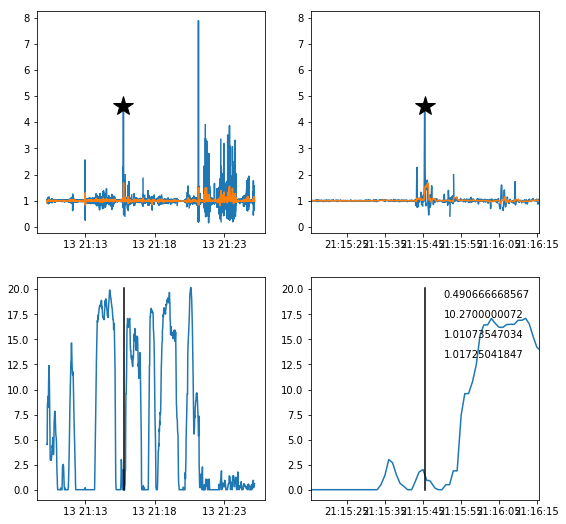

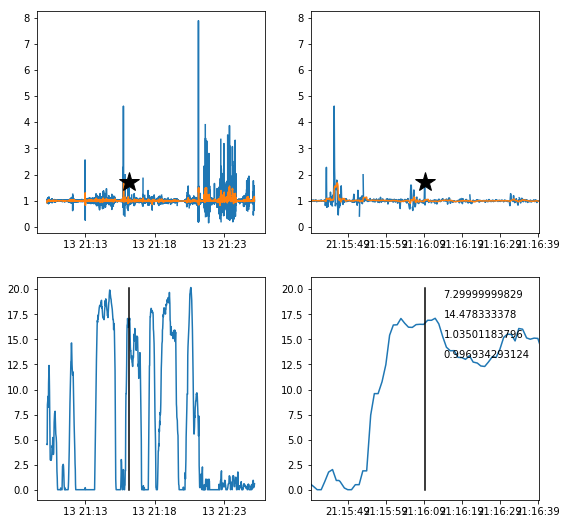

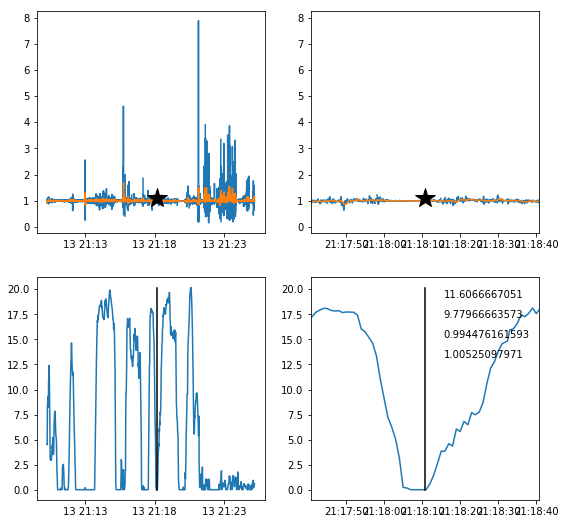

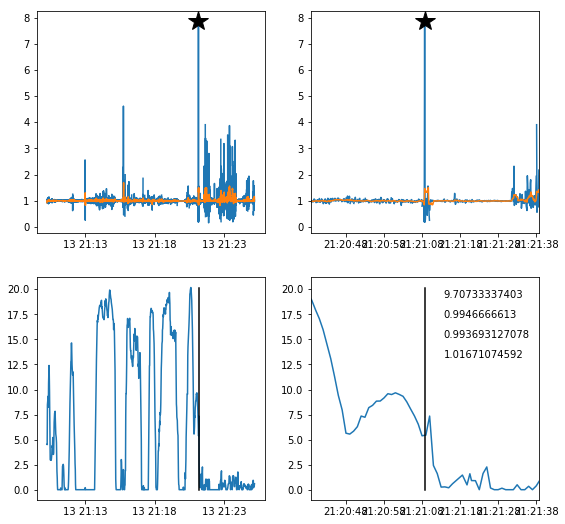

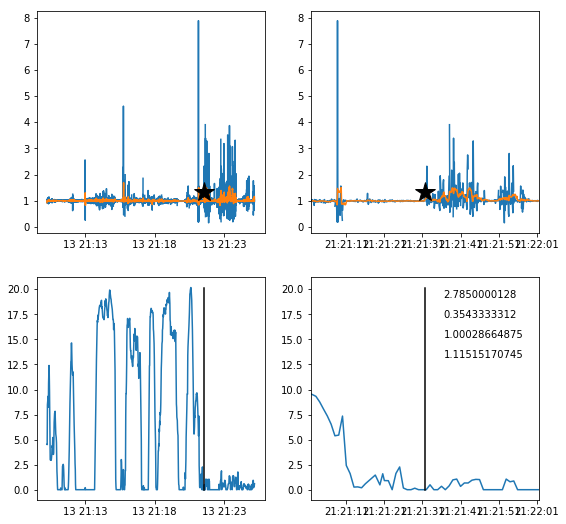

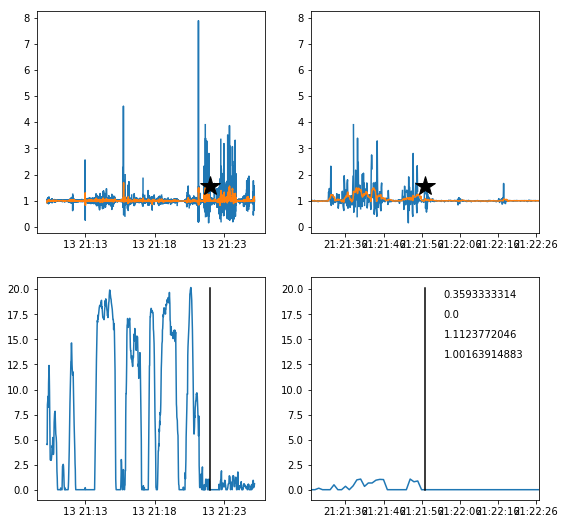

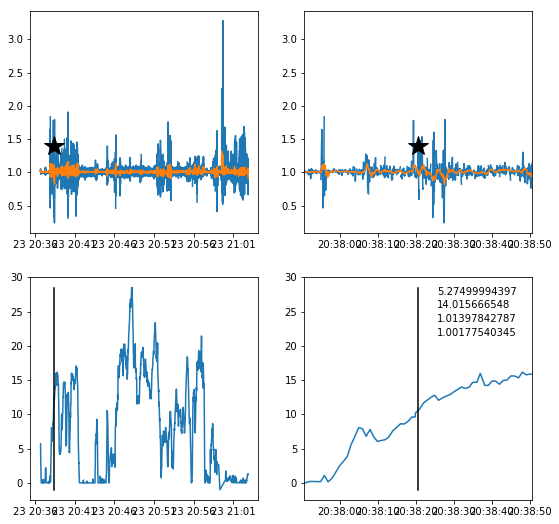

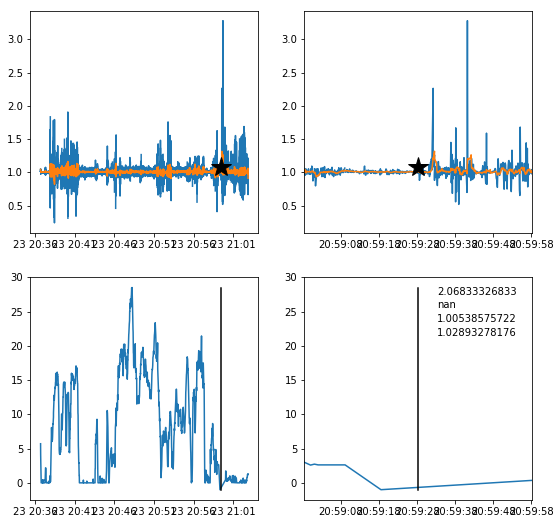

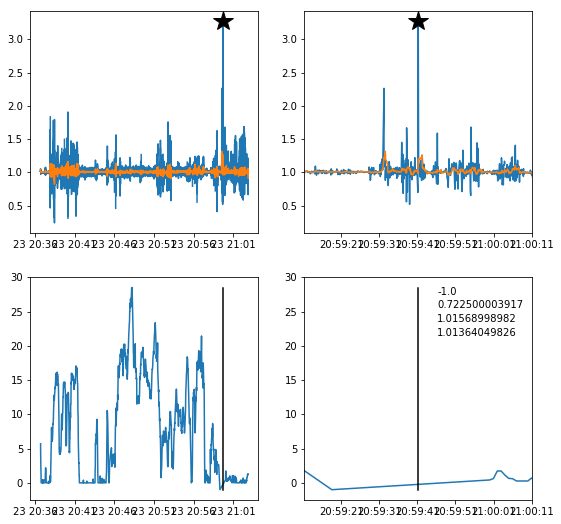

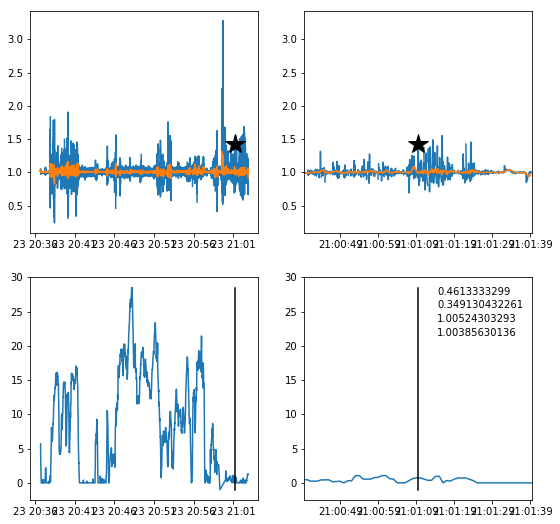

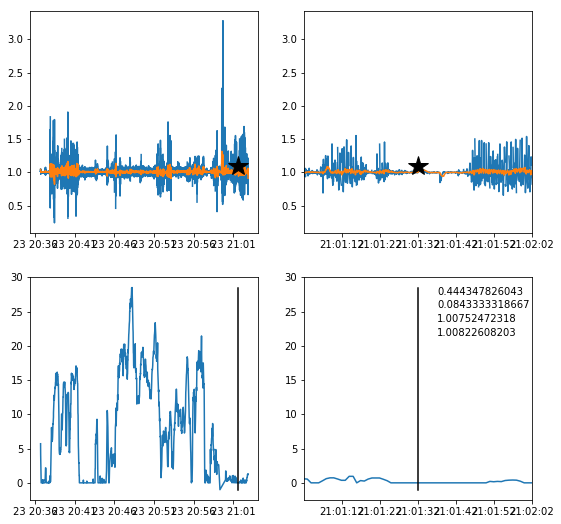

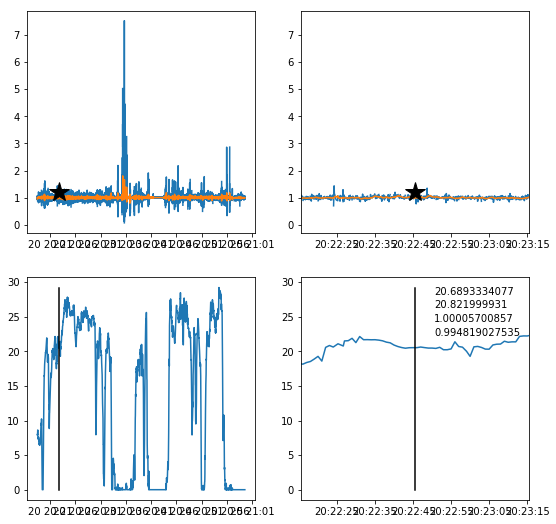

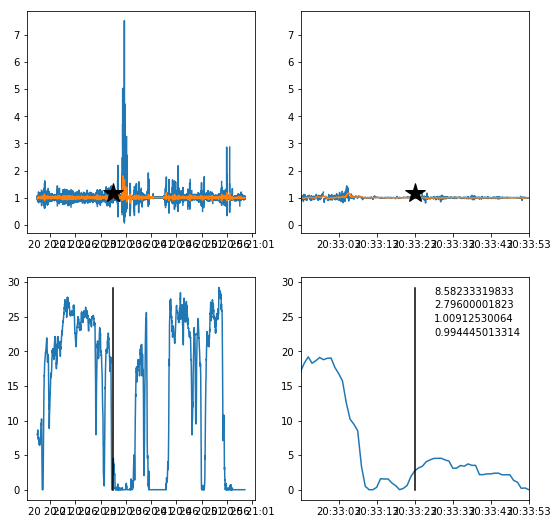

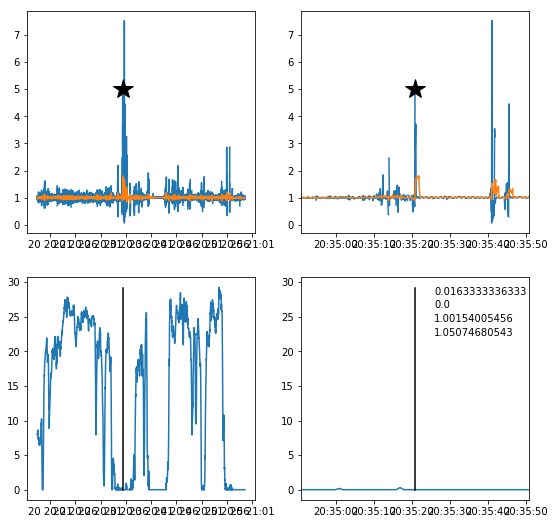

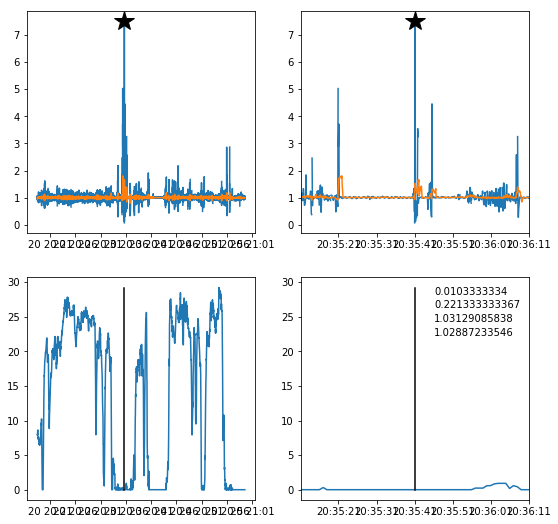

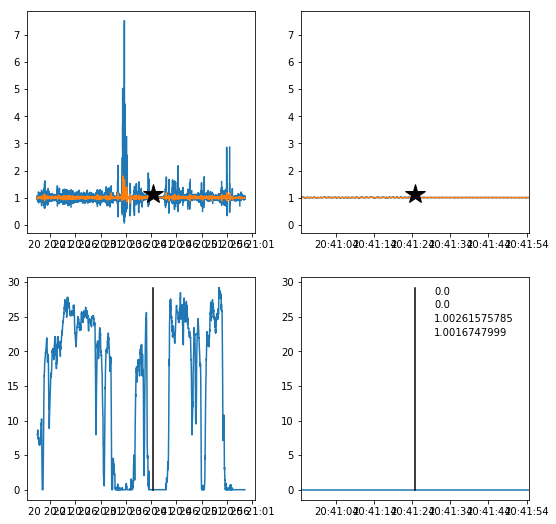

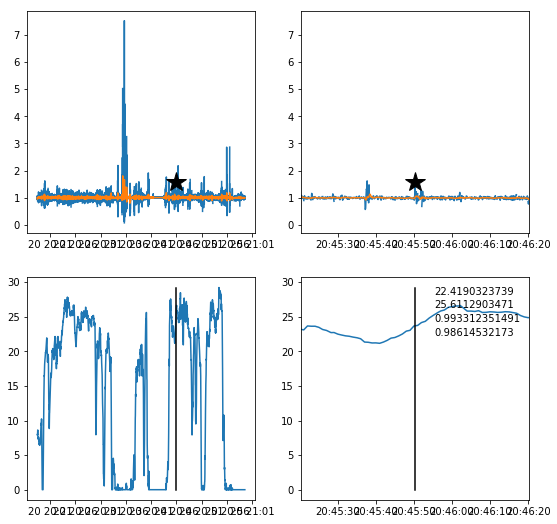

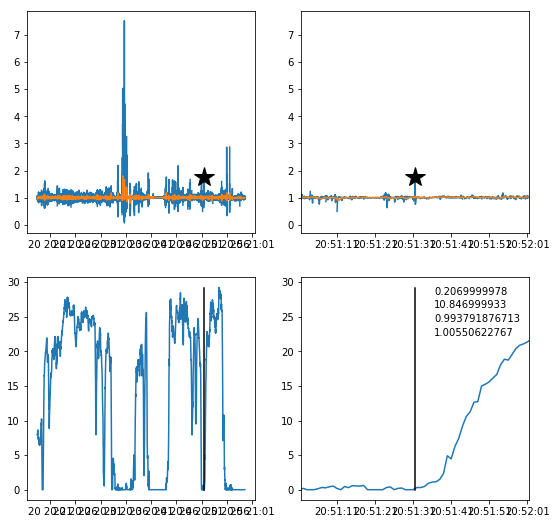

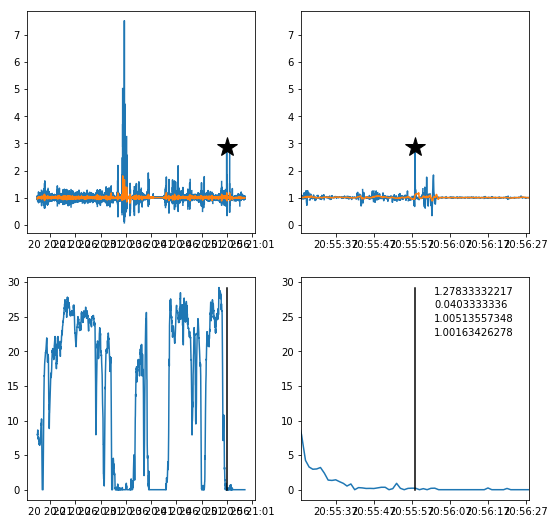

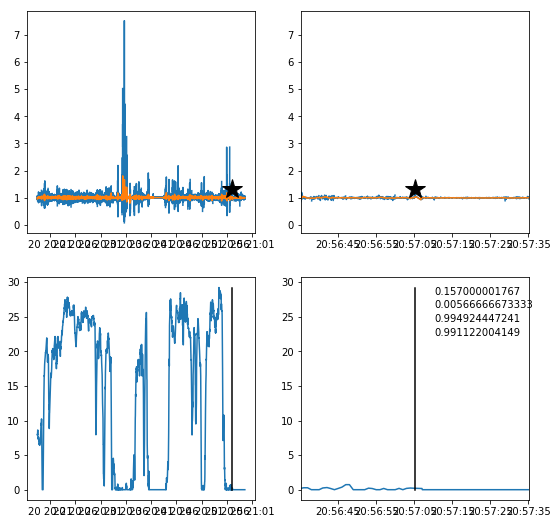

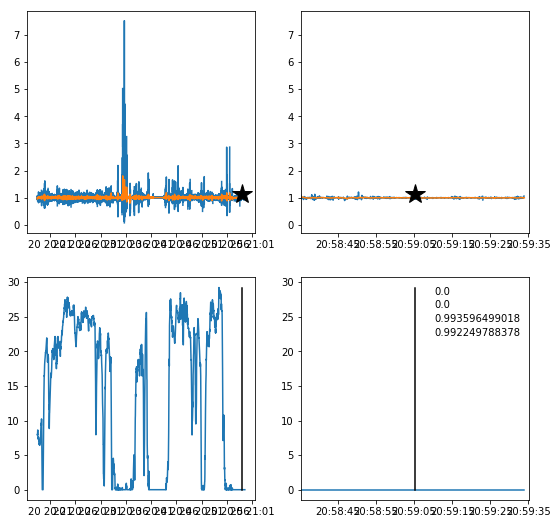

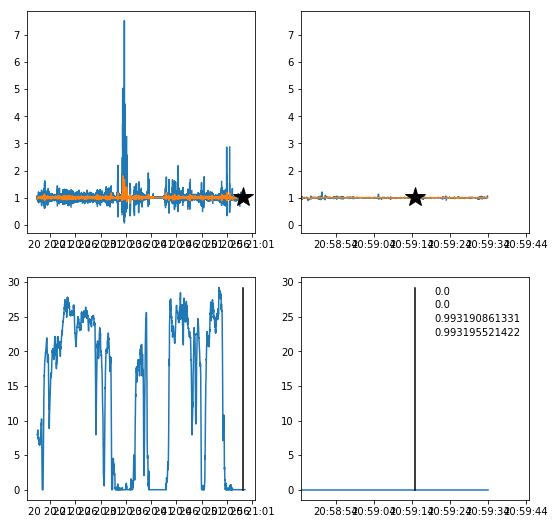

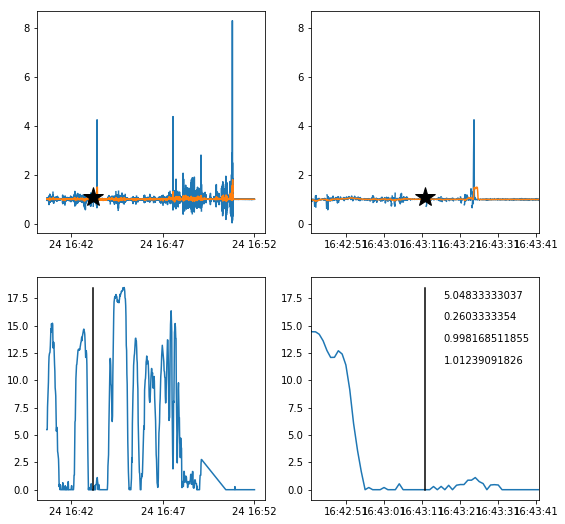

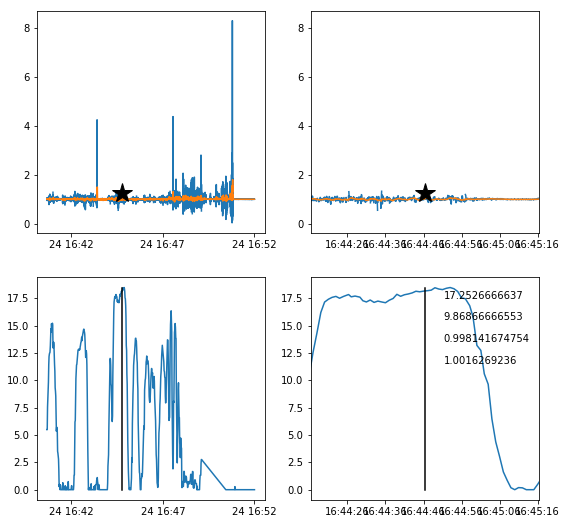

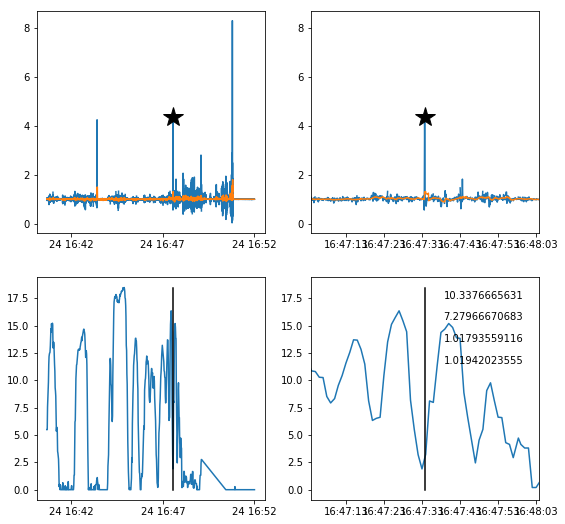

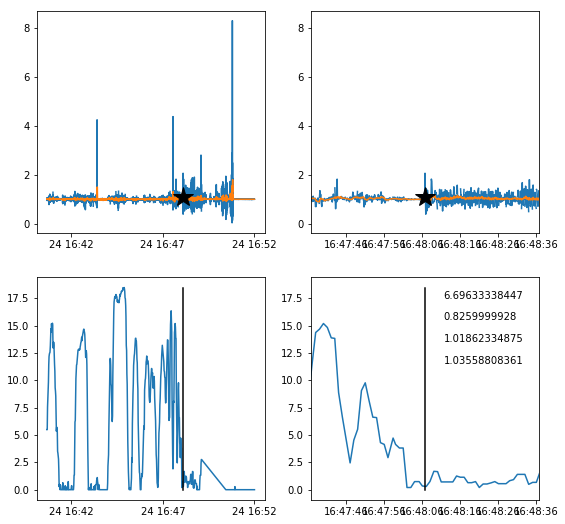

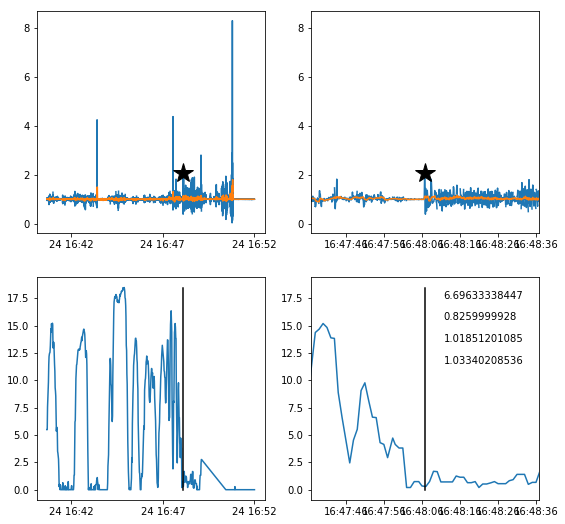

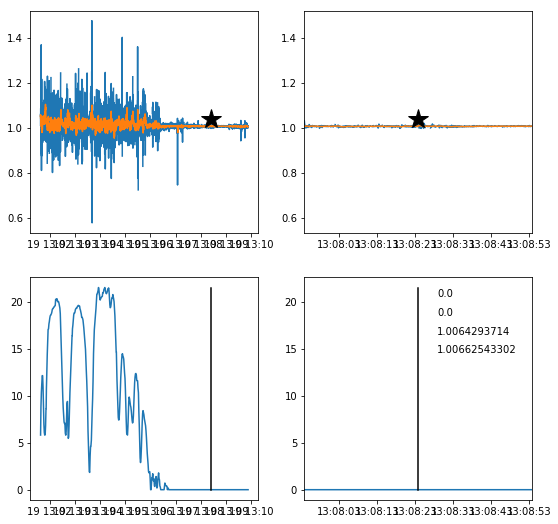

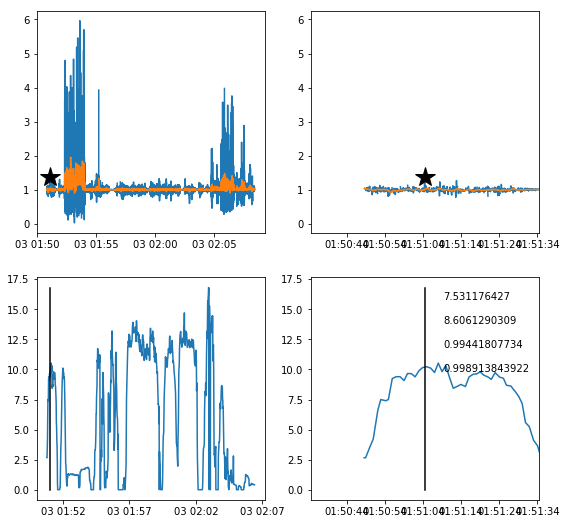

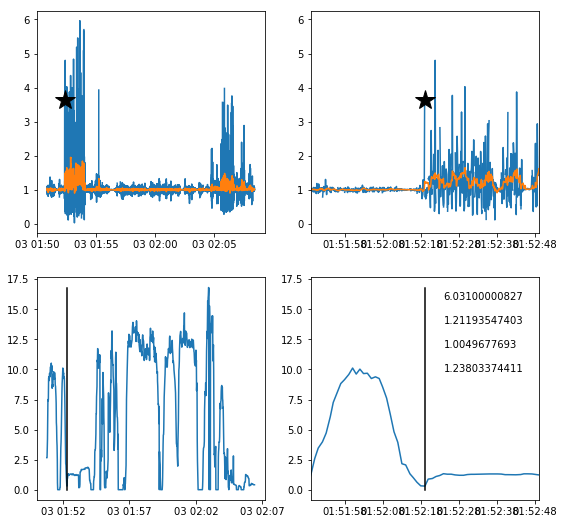

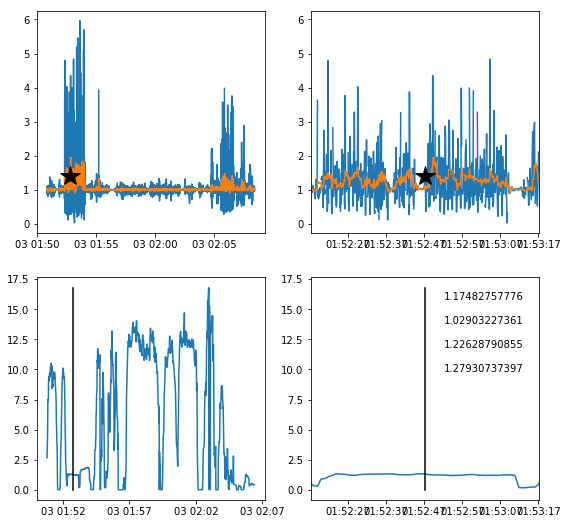

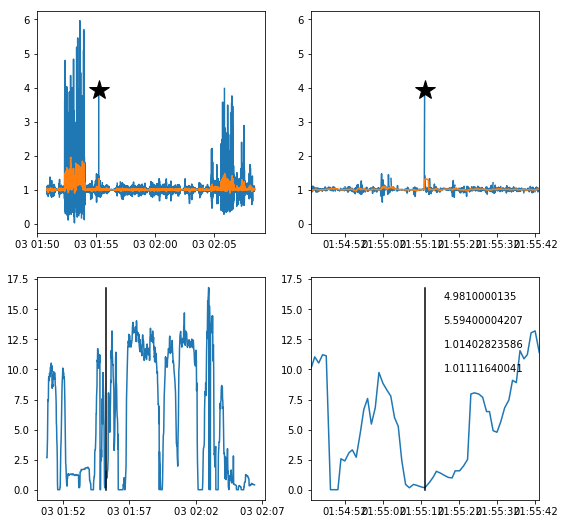

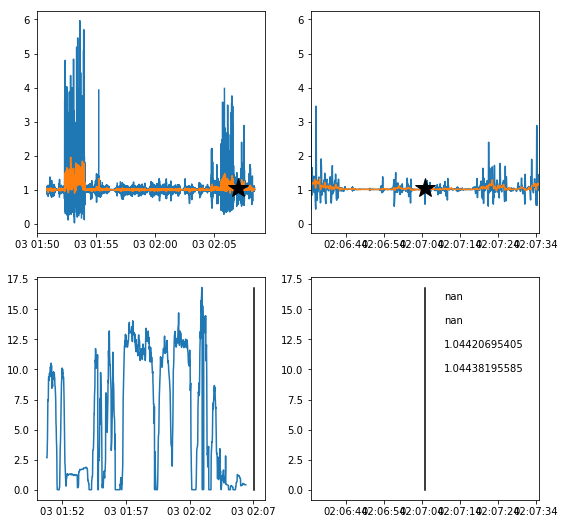

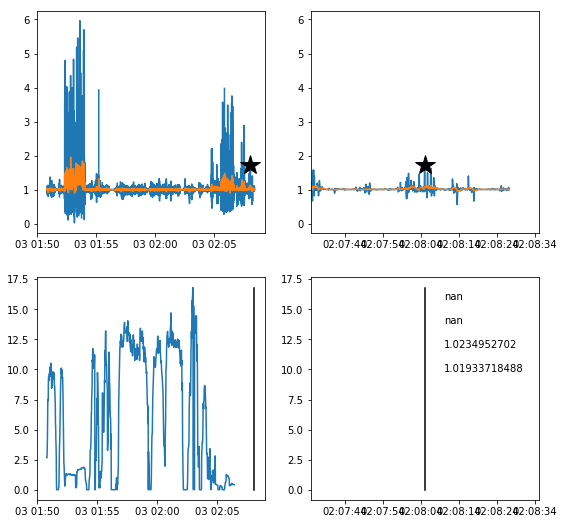

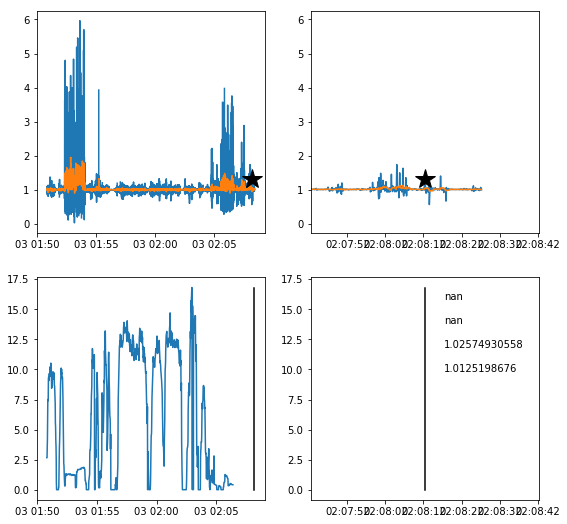

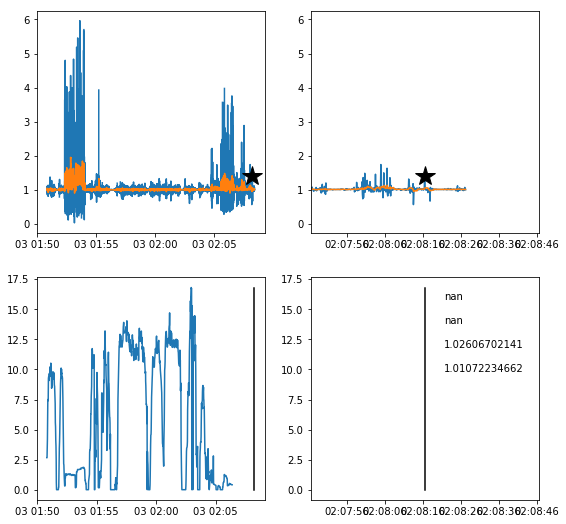

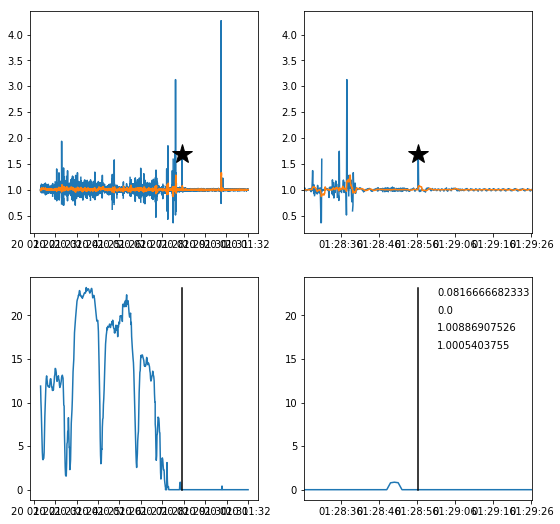

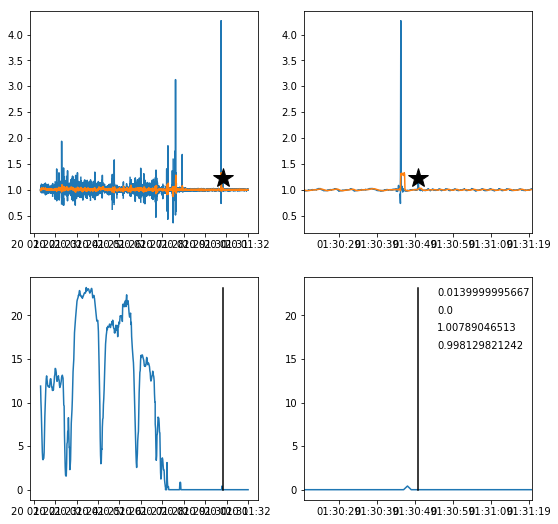

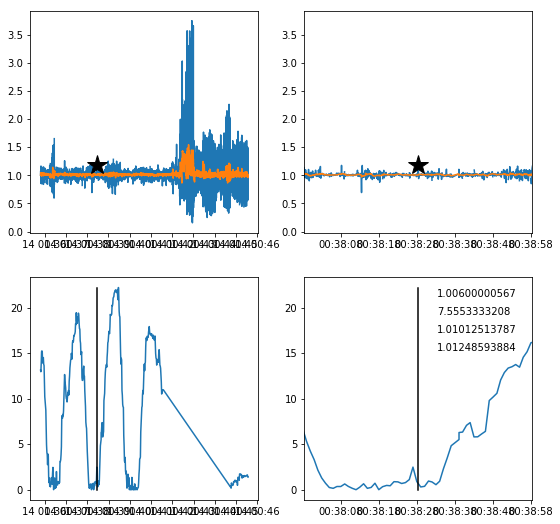

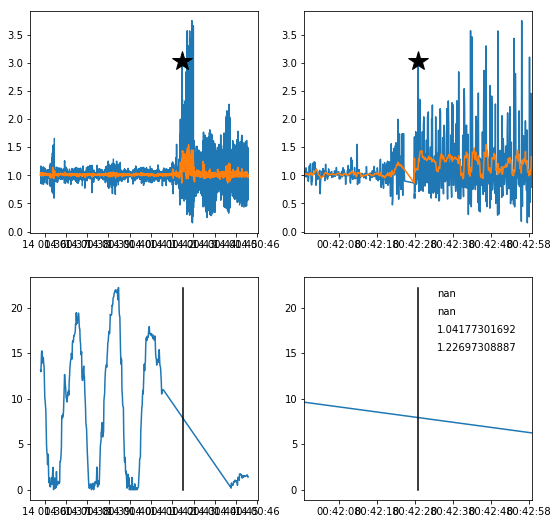

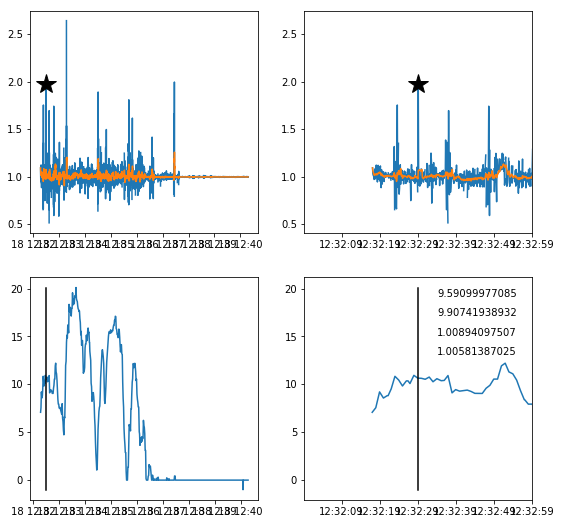

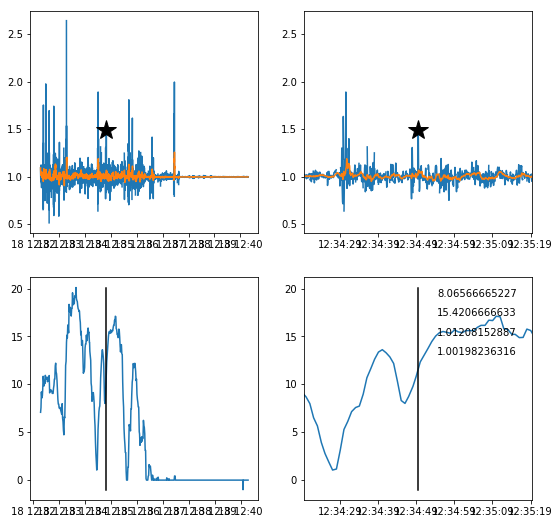

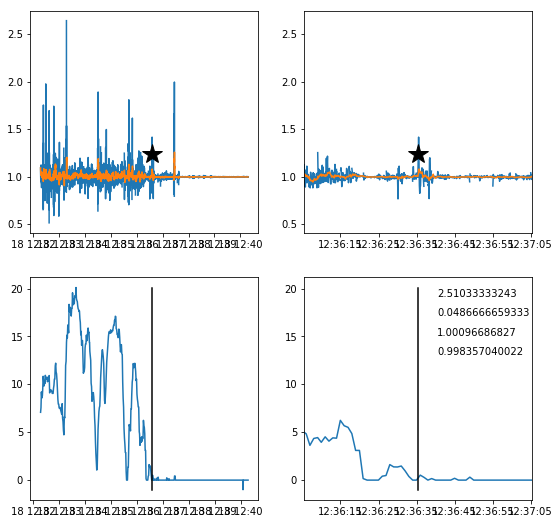

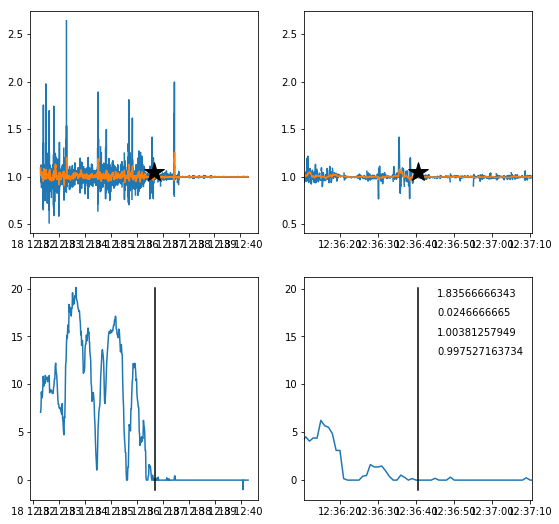

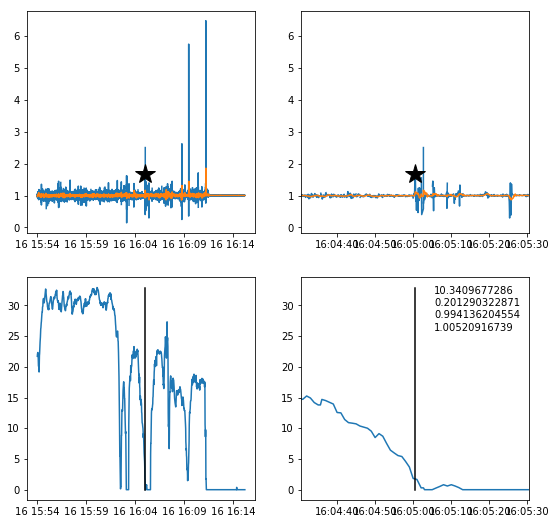

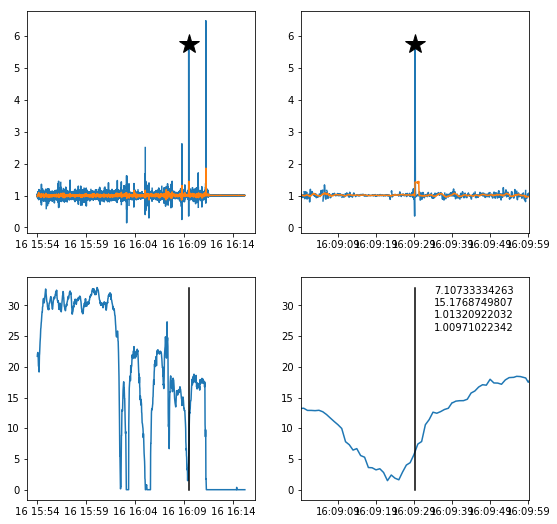

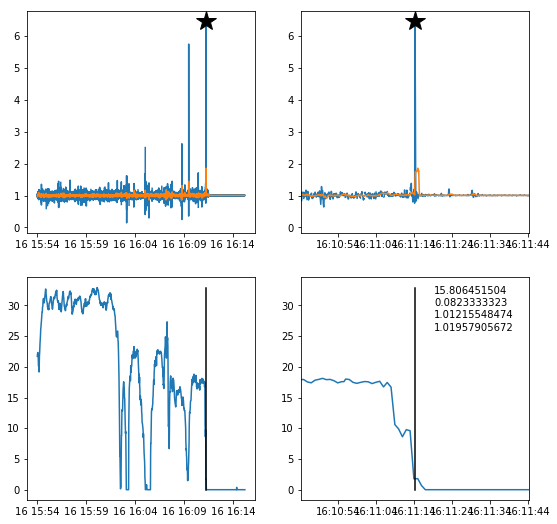

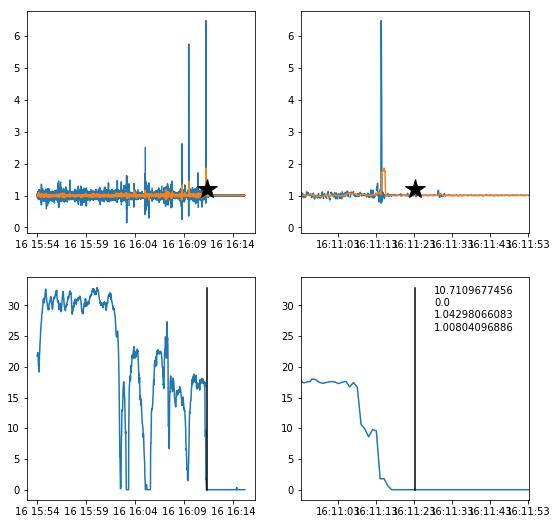

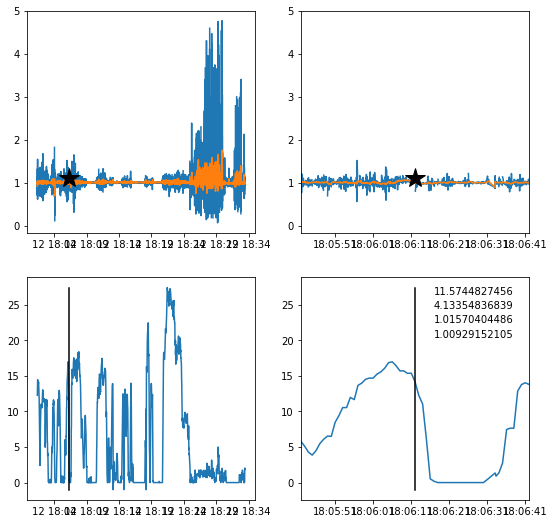

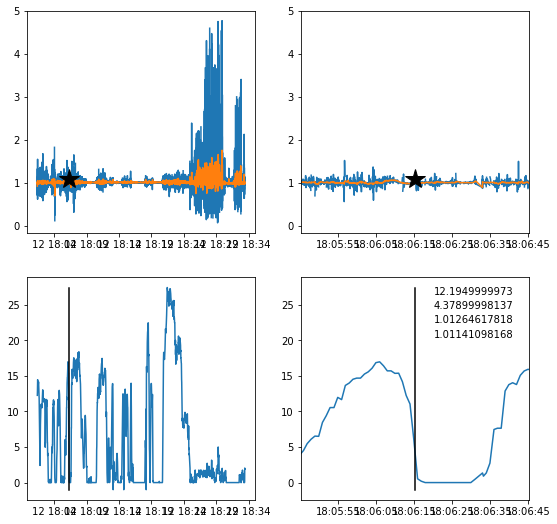

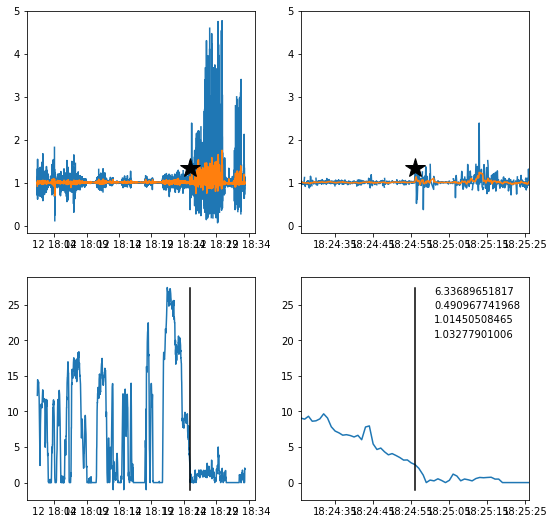

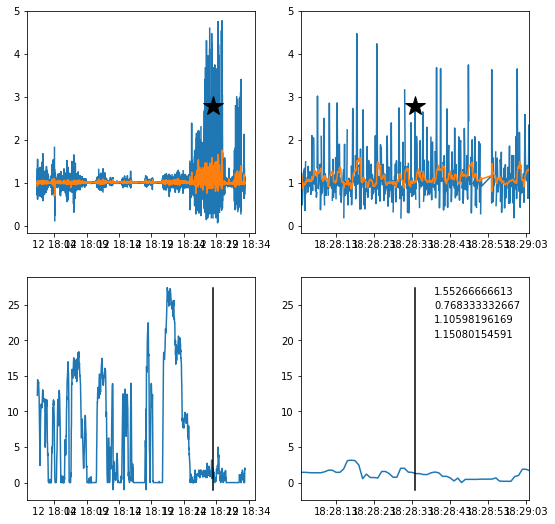

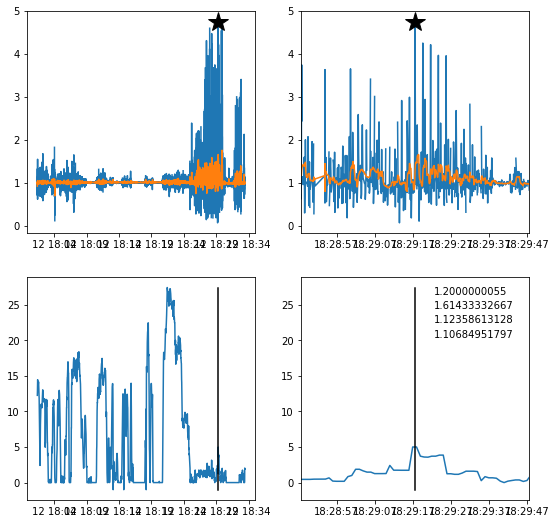

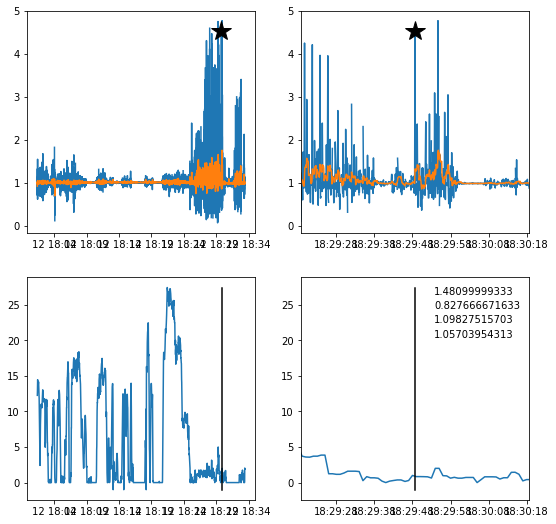

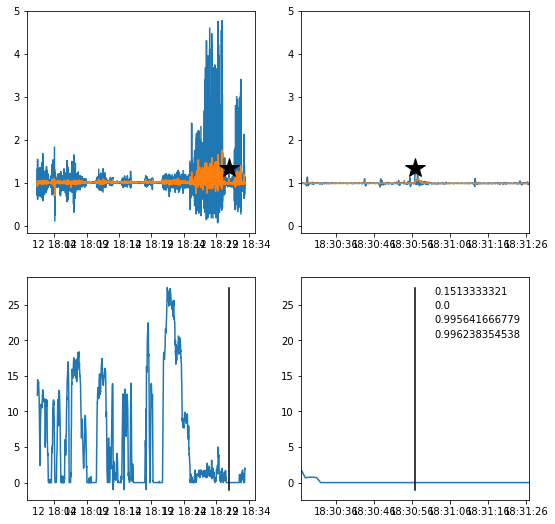

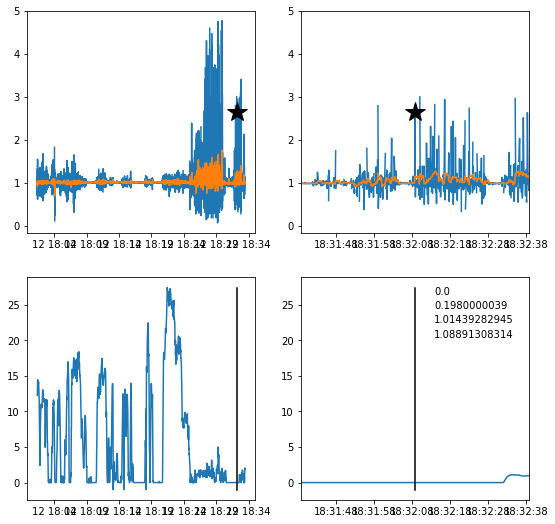

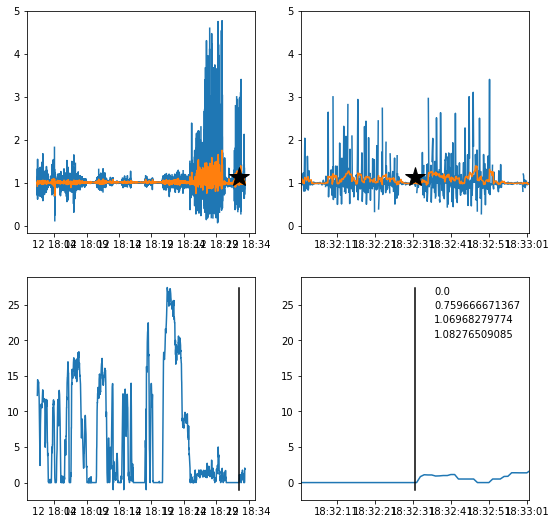

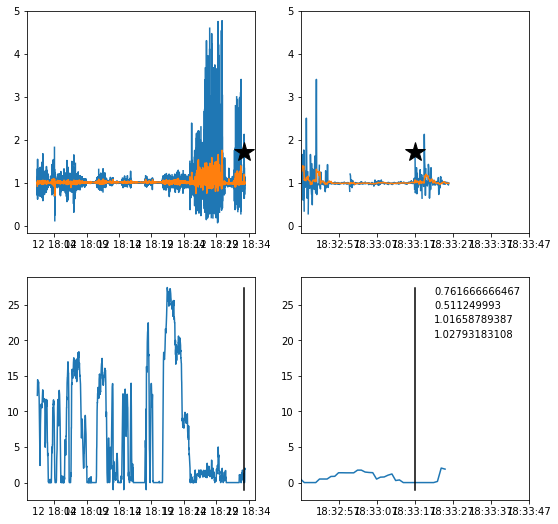

In [73]:
for i in range(0,len(event.index)):
    Plot_crash(event.iloc[i:i+1],sorted_dfs[event.driver[i]], rolling_mean[event.driver[i]])
    
    
    
    

In [22]:
event.iloc[0:1].speed_before[0]

0.91799999813333322

In [ ]:
for df in dfs:
    df['mag'] = np.sqrt(df['x']**2+df['y']**2+df['z']**2)
    df['time'] = pd.to_datetime(df['timestamp'], unit='ms')
dfs[0].head(5)

In [23]:
list[0] = 0.0
for each df
for 1 to the end
lat 1 = df[]
lat 2 = df[+1]
lon 1
lon 2


a = 



SyntaxError: invalid syntax (<ipython-input-23-9e515c1ba42e>, line 2)

In [55]:
test = dfs[0][['lat','lon','timestamp']].dropna(axis=0)
test.head(5)

lat        lon     timestamp
0   41.978753 -87.893018  1.431035e+12
10  41.978630 -87.892898  1.431035e+12
22  41.978554 -87.892800  1.431035e+12
33  41.978450 -87.892692  1.431035e+12
44  41.978393 -87.892630  1.431035e+12

In [71]:
distance = []
distance.append(0)
for i in range(1,len(test.index)):
    lat1 = test.lat.iloc[i-1]
    lat2 = test.lat.iloc[i]
    lon1 = test.lon.iloc[i-1]
    lon2 = test.lon.iloc[i]
    
    
    
    a = (np.sin((lat2 - lat1)/2))**2 + (np.cos(lat1) * np.cos(lat2) * (np.sin((lon2 - lon1)/2))**2)
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1 - a))
    sofar = np.sum(distance)
    d = (6371.0*c)
    #distance.append((6371.0 * c))
    distance.append(d)
    #print(lat1,lat2,lon1,lon2)
    print (sofar,d)
    
#print(i,d)

0 0.846665933635
0.846665933635 0.55130031778
1.39796625142 0.724520775738
2.12248702715 0.399547391075
2.52203441823 0.622655977625
3.14469039585 0.690912205659
3.83560260151 0.717411961072
4.55301456258 0.584980974297
5.13799553688 0.688031038168
5.82602657505 0.736192175358
6.56221875041 0.643504781134
7.20572353154 0.578366143416
7.78408967496 0.589480217185
8.37356989214 0.571254587678
8.94482447982 0.610923053664
9.55574753349 0.63604443828
10.1917919718 0.64261951584
10.8344114876 0.437971353713
11.2723828413 0.546572182582
11.8189550239 0.536497190931
12.3554522148 0.54347357646
12.8989257913 0.461617064017
13.3605428553 0.558674437506
13.9192172928 0.509004872855
14.4282221657 0.617458623457
15.0456807891 0.504153604343
15.5498343935 0.548396561406
16.0982309549 0.406087138883
16.5043180938 0.531711642802
17.0360297366 0.432678943887
17.4687086804 0.539904744964
18.0086134254 0.544250954782
18.5528643802 0.669020250863
19.2218846311 0.566534304251
19.7884189353 0.522803680567


170.454508649 0.0
170.454508649 0.0
170.454508649 0.0
170.454508649 0.0
170.454508649 0.0
170.454508649 0.0823784146965
170.536887064 0.13216167546
170.66904874 0.0377039137892
170.706752653 0.0605447529607
170.767297406 0.066818350198
170.834115756 0.0887551309006
170.922870887 0.138251242919
171.06112213 0.507743502725
171.568865633 0.134350414081
171.703216047 0.171438413205
171.87465446 0.0769547557005
171.951609216 0.1852224854
172.136831701 0.302386327107
172.439218029 0.166427113697
172.605645142 0.508592338666
173.114237481 0.656230557388
173.770468038 0.646353405989
174.416821444 0.364007943759
174.780829388 0.429278434126
175.210107822 2.28486699972
177.494974822 0.822975836798
178.317950659 0.810955042828
179.128905701 0.689329108403
179.81823481 0.453863692732
180.272098503 0.627841960159
180.899940463 0.543342431607
181.443282894 0.543093497817
181.986376392 0.613996925568
182.600373318 0.550494672965
183.150867991 0.67434606257
183.825214053 0.612908336964
184.43812239 0.

444.032209492 0.951646624948
444.983856117 0.969376079915
445.953232196 1.04174192199
446.994974118 1.01440549772
448.009379616 0.970219437276
448.979599053 0.836861726962
449.81646078 0.788852700518
450.605313481 1.03532403687
451.640637518 0.960482416522
452.601119934 0.976610216443
453.577730151 0.723151257422
454.300881408 0.933079317096
455.233960725 1.273556471
456.507517196 1.16271865265
457.670235849 1.04090203702
458.711137886 1.16595462351
459.877092509 0.818116206053
460.695208716 1.10021222796
461.795420943 1.09589002353
462.891310967 1.24938587715
464.140696844 1.09040009831
465.231096942 0.487008420255
465.718105363 0.783649161159
466.501754524 0.906106960465
467.407861484 1.19814013741
468.606001622 0.765445092479
469.371446714 1.06966221444
470.441108929 0.430772829611
470.871881758 0.913429000671
471.785310759 0.967066097505
472.752376856 0.866384671011
473.618761527 1.01180306983
474.630564597 0.918738067583
475.549302665 0.875665876886
476.424968542 0.793891375423
47

In [69]:
distance

[0,
 0.84666593363522491,
 1.3979662514151765,
 2.9691529607887164,
 5.6133325369138758,
 11.449773660378005,
 22.967803548790279,
 45.96210685299345,
 91.791782719212051,
 183.68661550229484,
 367.42139214177968,
 734.75009688933505,
 1469.435055140953,
 2938.881224355674,
 5877.7442230818424,
 11755.528114629669,
 23511.081350643955,
 47022.169276365472,
 94044.133904568822,
 188088.37640996653,
 376176.74274494138,
 752353.49246626825,
 1504706.903076024,
 3009413.9032094213,
 6018827.7567492789,
 12037655.621952306,
 24075311.130599596,
 48150622.305442147,
 96301244.468574867,
 192602489.06277424,
 385204978.02651578,
 770409956.16025734,
 1540819912.324861,
 3081639824.7744913,
 6163279649.446497,
 12326559298.849264,
 24653118597.65937,
 49306237195.407944,
 98612474390.852966,
 197224948781.55356,
 394449897563.20441,
 788899795125.854,
 1577799590252.2385,
 3155599180503.9463,
 6311198361008.4209,
 12622396722017.002,
 25244793444033.836,
 50489586888067.836,
 100979173776135.

/Users/scottclay/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1747: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


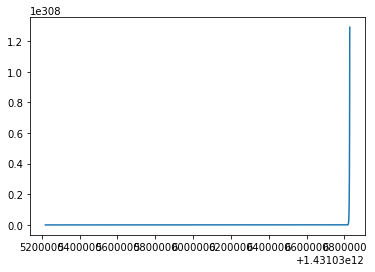

In [59]:
plt.plot(test.timestamp, distance)

In [76]:
event.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2015-03-19 20:50:03.761870 to 2015-05-12 18:33:17.086110
Data columns (total 17 columns):
accuracy        0 non-null float64
bearing         0 non-null float64
height          0 non-null float64
lat             0 non-null float64
lon             0 non-null float64
mag             80 non-null float64
speed           0 non-null float64
timestamp       80 non-null float64
type            80 non-null object
x               80 non-null float64
y               80 non-null float64
z               80 non-null float64
driver          80 non-null int64
speed_before    75 non-null float64
speed_after     74 non-null float64
mag_before      80 non-null float64
mag_after       80 non-null float64
dtypes: float64(15), int64(1), object(1)
memory usage: 13.8+ KB


In [77]:
event2 = event[ (event.speed_before > event.speed_after)]

In [78]:
event2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2015-03-19 21:07:17.232870 to 2015-05-12 18:33:17.086110
Data columns (total 17 columns):
accuracy        0 non-null float64
bearing         0 non-null float64
height          0 non-null float64
lat             0 non-null float64
lon             0 non-null float64
mag             40 non-null float64
speed           0 non-null float64
timestamp       40 non-null float64
type            40 non-null object
x               40 non-null float64
y               40 non-null float64
z               40 non-null float64
driver          40 non-null int64
speed_before    40 non-null float64
speed_after     40 non-null float64
mag_before      40 non-null float64
mag_after       40 non-null float64
dtypes: float64(15), int64(1), object(1)
memory usage: 5.6+ KB


1.59684426848
2.18743381901
1.07422021778
2.55785945529
1.03946359213
0.770084998784


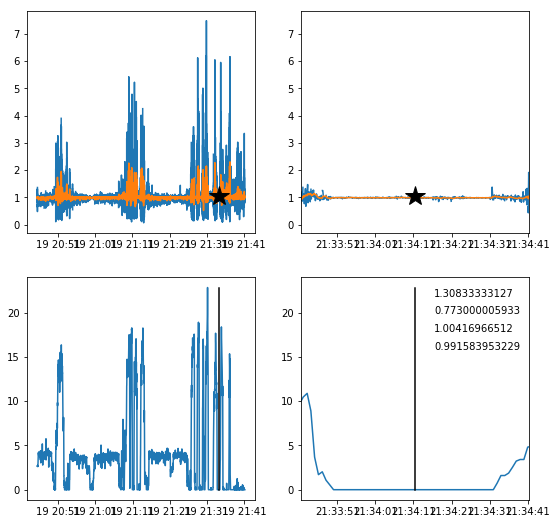

1.08809064945
3.81844441585
2.53515295875
0.0321768011968


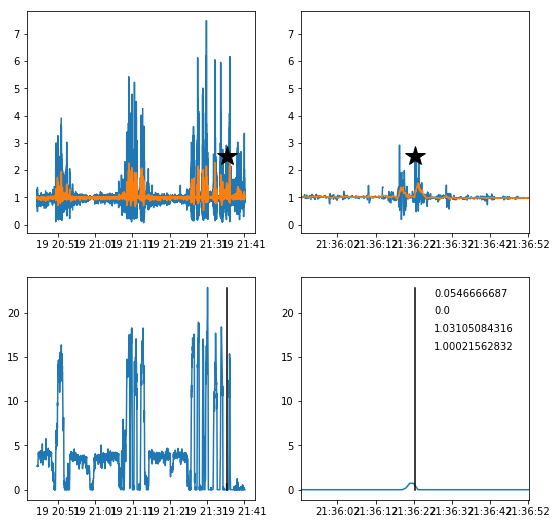

2.15125799144
4.23419217496
1.30146131998
1.18838339821


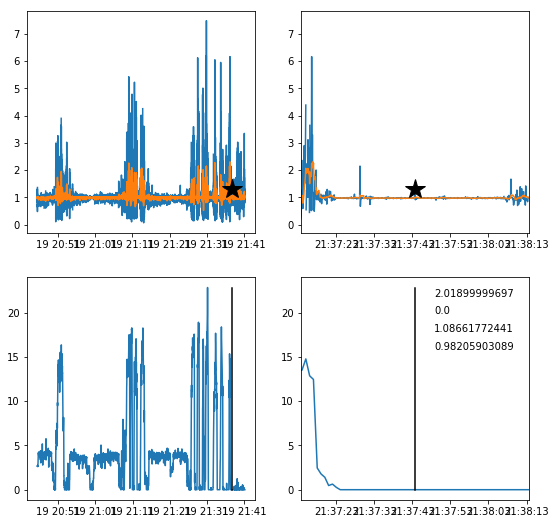

2.61012842349
0.0623915998627


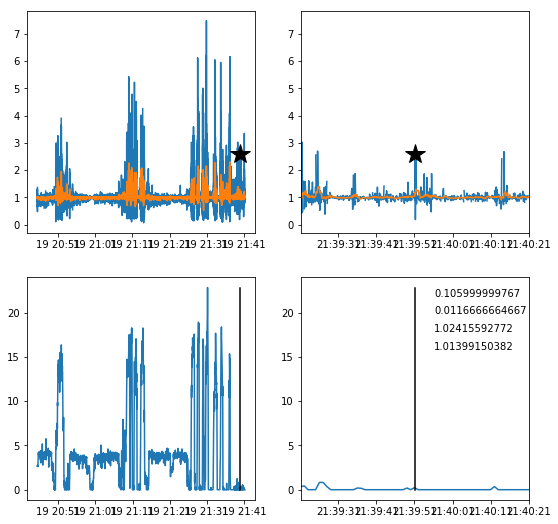

2.04233396487
0.0207971997646


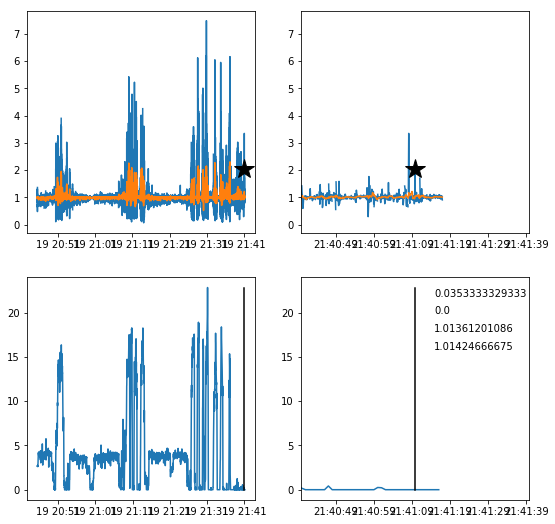

1.09325318181
6.8316840226
7.87947406308
5.71373642396


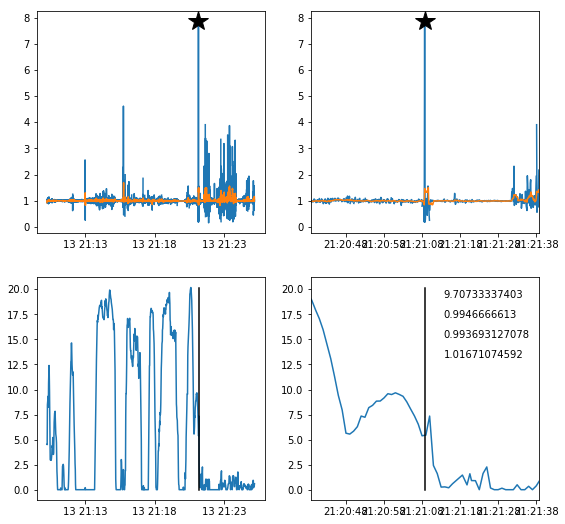

1.33596135447
1.63925100753
1.56588904895
0.211503598862


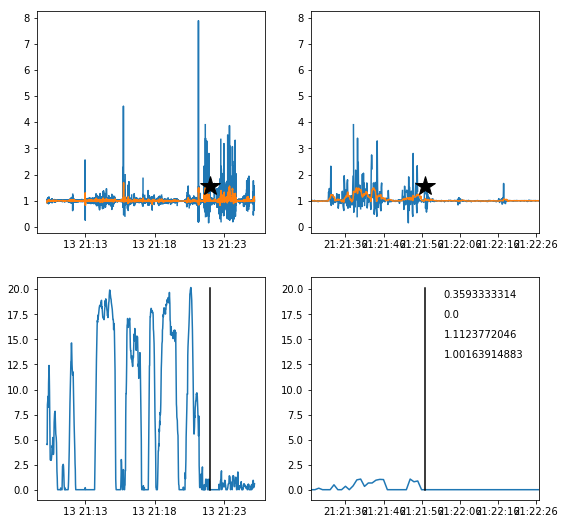

1.42759186332
0.271540797979


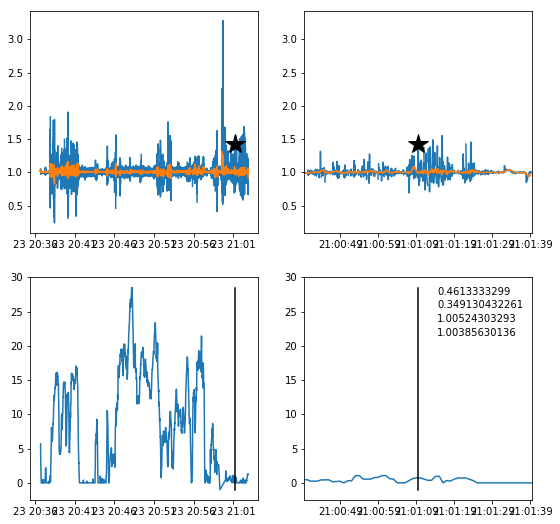

1.10114454932
0.261543130409


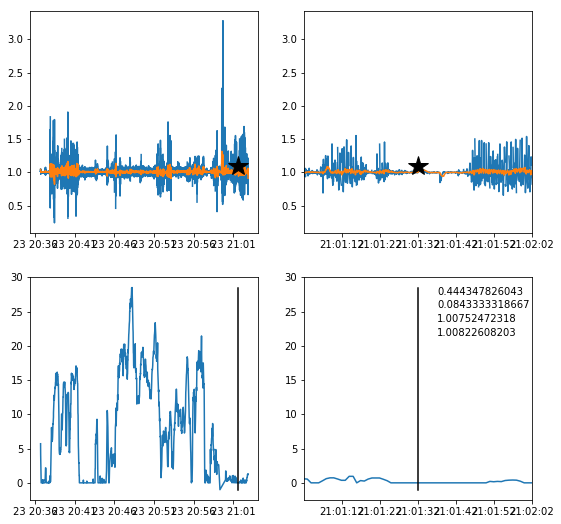

1.1619289414
5.05156132054
5.02708796193
0.00961380017658


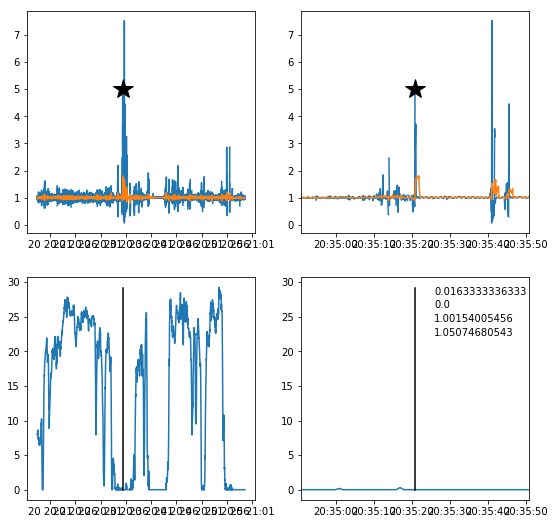

2.86325248522
0.752426993427


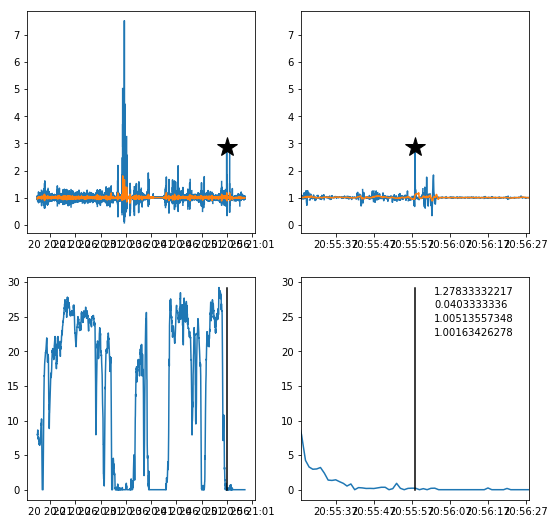

1.33483417672
0.0924102010399


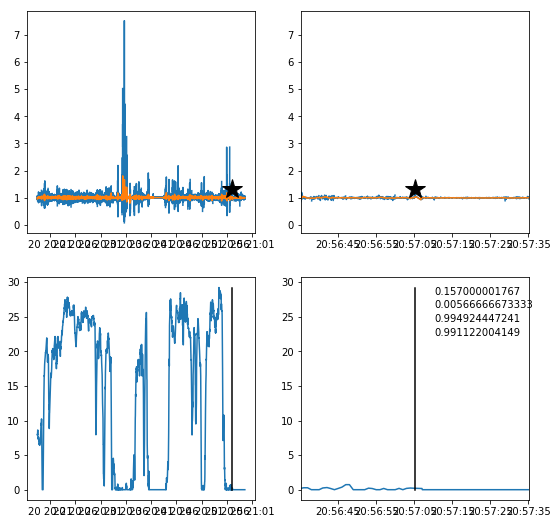

1.08372376517
2.97144899825
1.25587016752
10.1549195982
4.3835231685
6.08475053906
1.07967698283
3.9414618301
2.06536171627
3.9414618301
3.62496876761
3.54984660487


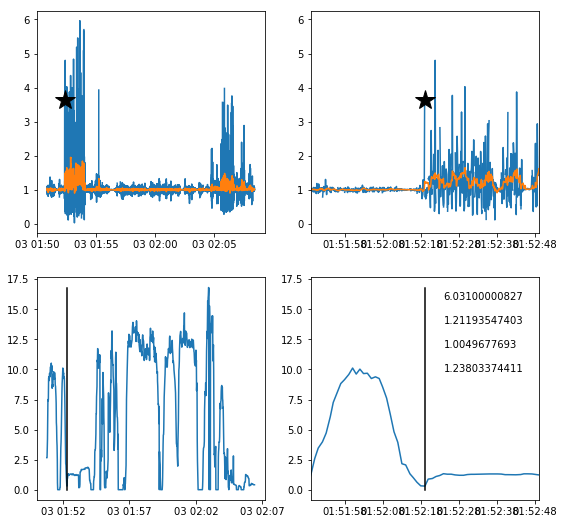

1.39384255206
0.691503512269


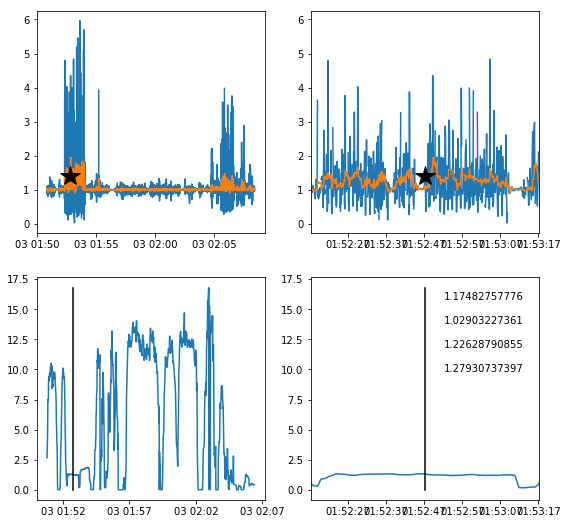

1.68243036071
0.0480690009221


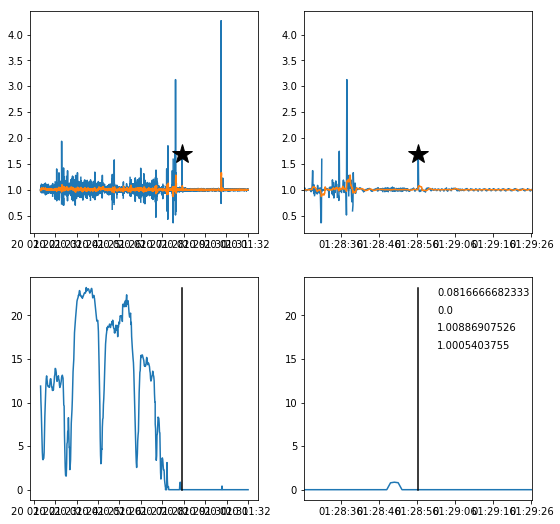

1.22672199605
0.00824039974494


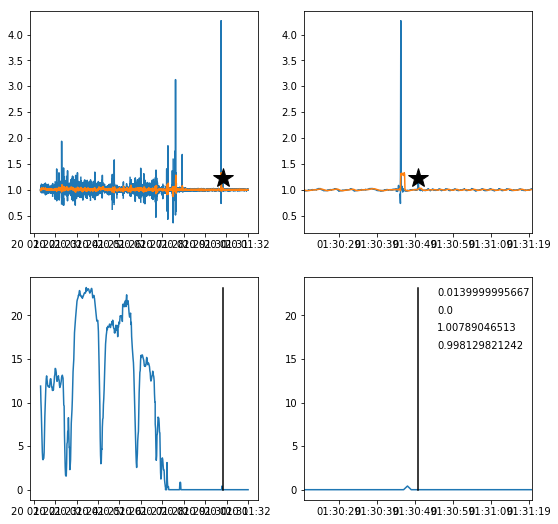

1.23846113429
1.47758219947
1.05504368383
1.0804733981
1.68657756864
6.08669360506
6.48419029435
9.30367735525
1.20071993507
6.30447561505
1.12064901095
6.81274054407
1.08633560758
7.17797699843
1.3487650075
3.7298972906
2.78029611179
0.913899599686


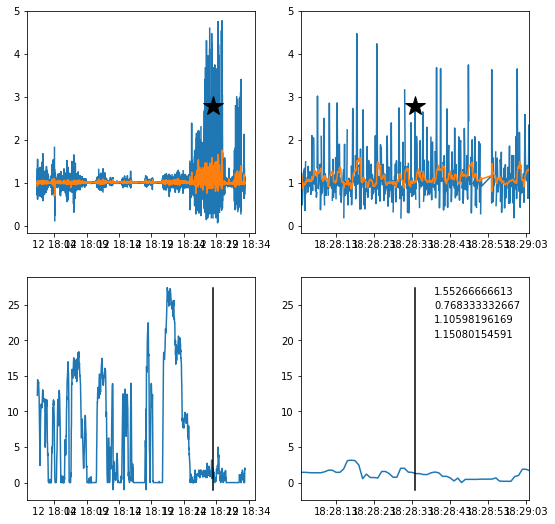

4.54431878407
0.871716596076


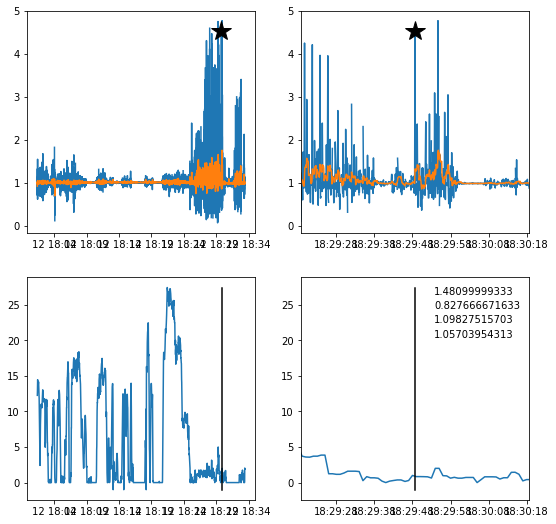

1.34078970763
0.0890747992741


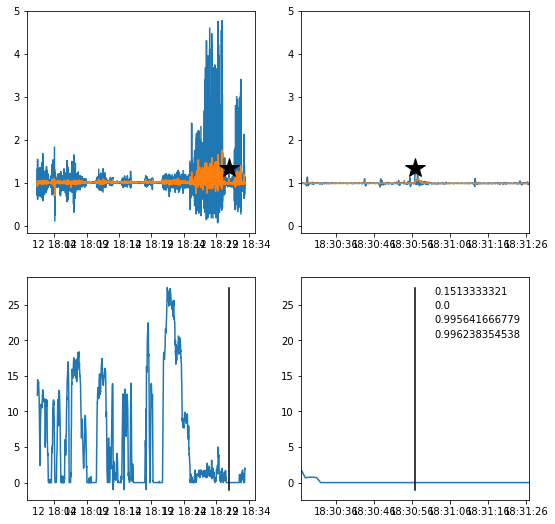

1.72610033168
0.448316999882


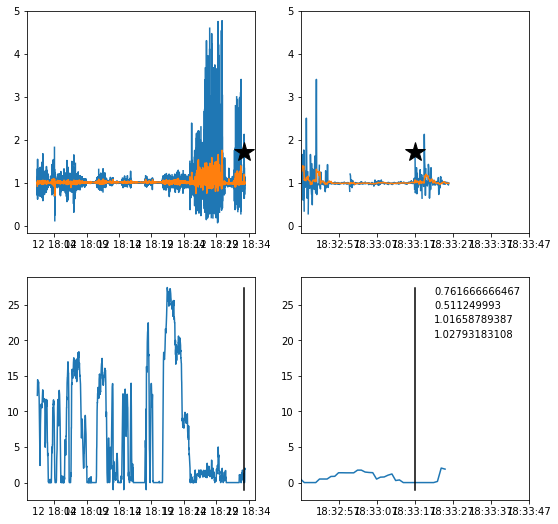

In [102]:
for i in range(0,len(event2.index)):
    print(event2.mag[i])
    SD = event2.speed_before[i] / (2.0 * 0.6 * 9.81)
    a = (event2.speed_before[i]**2)/(2. * SD)
    print(a/10)
    if a/10 < event2.mag[i]:
        Plot_crash(event2.iloc[i:i+1],sorted_dfs[event2.driver[i]], rolling_mean[event2.driver[i]])
    
    
    
    

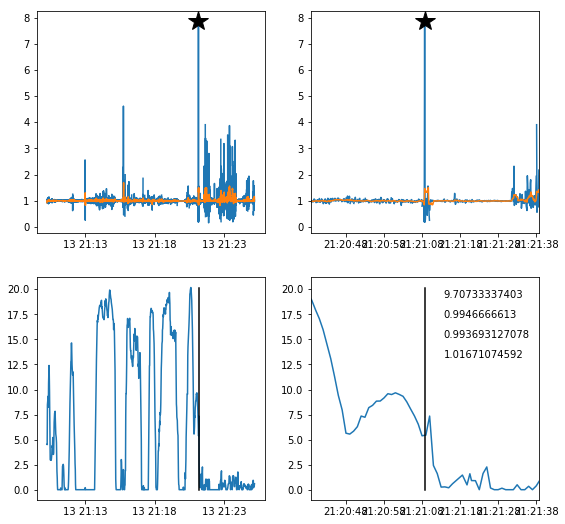

In [80]:
i=10
Plot_crash(event2.iloc[i:i+1],sorted_dfs[event2.driver[i]], rolling_mean[event2.driver[i]])
    
    
    
    

In [81]:
event2.iloc[i:i+1]

accuracy  bearing  height  lat  lon       mag  \
2015-04-13 21:21:08.665980       NaN      NaN     NaN  NaN  NaN  7.879474   

                            speed     timestamp           type         x  \
2015-04-13 21:21:08.665980    NaN  1.428960e+12  accelerometer  2.498718   

                                   y         z  driver  speed_before  \
2015-04-13 21:21:08.665980  1.774841 -7.258957       7      9.707333   

                            speed_after  mag_before  mag_after  
2015-04-13 21:21:08.665980     0.994667    0.993693   1.016711

In [88]:
event2.head(5)

accuracy  bearing  height  lat  lon       mag  \
2015-03-19 21:07:17.232870       NaN      NaN     NaN  NaN  NaN  1.596844   
2015-03-19 21:29:20.649870       NaN      NaN     NaN  NaN  NaN  1.074220   
2015-03-19 21:34:11.403870       NaN      NaN     NaN  NaN  NaN  1.039464   
2015-03-19 21:35:34.149870       NaN      NaN     NaN  NaN  NaN  1.088091   
2015-03-19 21:36:22.383870       NaN      NaN     NaN  NaN  NaN  2.535153   

                            speed     timestamp           type         x  \
2015-03-19 21:07:17.232870    NaN  1.426799e+12  accelerometer -0.665009   
2015-03-19 21:29:20.649870    NaN  1.426801e+12  accelerometer -1.013565   
2015-03-19 21:34:11.403870    NaN  1.426801e+12  accelerometer -0.938400   
2015-03-19 21:35:34.149870    NaN  1.426801e+12  accelerometer -1.058868   
2015-03-19 21:36:22.383870    NaN  1.426801e+12  accelerometer -2.363846   

                                   y         z  driver  speed_before  \
2015-03-19 21:07:17.232870 -0.065903  1.450287       6      3.716333   
2015-03-19 21:29:20.649870  0.218277 -0.281052       6      4.345667   
2015-03-19 21:34:11.403870  0.431046  0.118698       6      1.308333   
2015-03-19 21:35:34.149870  0.219513  0.120636       6      6.487333   
2015-03-19 21:36:22.383870 -0.014313  0.915985       6      0.054667   

                            speed_after  mag_before  mag_after  
2015-03-19 21:07:17.232870     1.026667    0.984320   0.998906  
2015-03-19 21:29:20.649870     0.051000    1.121392   0.992954  
2015-03-19 21:34:11.403870     0.773000    1.004170   0.991584  
2015-03-19 21:35:34.149870     0.006333    1.027612   1.026026  
2015-03-19 21:36:22.383870     0.000000    1.031051   1.000216

In [91]:
event2.mag_before[1]

1.121391535650752